In [ ]:
## other potentials sources and methods
  # what about time per event, rather than just event per time?
  # https://anomaly.io/anomaly-detection-poisson-distribution/index.html

In [65]:
###############################
### Method 02

## STEP - read the data
import pandas as pd
cols_ = ['changeType', 'timestamp']
# df = pd.read_csv("sample_data_01b.csv", parse_dates=["timestamp"], sep='\t',usecols=cols_)
df_original = pd.read_csv("sample_data_01c.csv", parse_dates=["timestamp"], sep='\t',usecols=cols_)
df = df_original.copy()


In [66]:
# df_original
df.head(5)

,changeType,timestamp
0,Delete,2023-04-02 02:00:01
1,Modify,2023-01-01 15:27:14
2,Modify,2023-03-02 01:32:24
3,Delete,2022-08-30 23:45:10
4,Modify,2023-04-06 02:56:53


In [67]:
## STEP- preprocess the data

import pandas as pd
import numpy as np

# Step 1: Preprocess the data
# df['timestamp'] = pd.to_datetime(df['timestamp'])
df['timestamp'] = pd.to_datetime(df['timestamp']).dt.floor('H')  # flooring the timestamp to hour
df['hour'] = df['timestamp'].dt.hour
df['day'] = df['timestamp'].dt.day

# df['month'] = df['timestamp'].dt.month # NOTE: this is not necessary if full year's data is not available.
# df['year'] = df['timestamp'].dt.year # NOTE: this is not necessary if multiple year's data is not available.
df['day_of_week'] = df['timestamp'].dt.dayofweek + 1 # NOTE: this could be made as binary (WeekDay vs WeekEnd)?

# Step 2: Encode categorical variables
# NOTE: encode other categorial variables if necessary
for col in ['changeType']:
    # df[f"{col}_encoded"] = pd.Categorical(df[col]).codes
    ## staring encoding from 1 rather than 0
    df[f"{col}_encoded"] = pd.Categorical(df[col]).codes + 1


In [68]:
df

,changeType,timestamp,hour,day,day_of_week,changeType_encoded
0,Delete,2023-04-02 02:00:00,2,2,7,2
1,Modify,2023-01-01 15:00:00,15,1,7,3
2,Modify,2023-03-02 01:00:00,1,2,4,3
3,Delete,2022-08-30 23:00:00,23,30,2,2
4,Modify,2023-04-06 02:00:00,2,6,4,3
...,...,...,...,...,...,...
99995,Modify,2023-02-20 23:00:00,23,20,1,3
99996,Delete,2022-09-16 04:00:00,4,16,5,2
99997,Delete,2022-09-21 04:00:00,4,21,3,2
99998,Write,2022-09-10 06:00:00,6,10,6,4


In [69]:

## Aggregate the data by unique row and then count
df_with_count = df.groupby(df.columns.tolist(), as_index=False).size().rename(columns={'size':'count'})
df_with_count

,changeType,timestamp,hour,day,day_of_week,changeType_encoded,count
0,Create,2022-08-01 01:00:00,1,1,1,1,4
1,Create,2022-08-01 02:00:00,2,1,1,1,3
2,Create,2022-08-01 03:00:00,3,1,1,1,5
3,Create,2022-08-01 04:00:00,4,1,1,1,6
4,Create,2022-08-01 05:00:00,5,1,1,1,5
...,...,...,...,...,...,...,...
21210,Write,2023-04-12 19:00:00,19,12,3,4,2
21211,Write,2023-04-12 20:00:00,20,12,3,4,3
21212,Write,2023-04-12 21:00:00,21,12,3,4,8
21213,Write,2023-04-12 22:00:00,22,12,3,4,1


In [70]:
## NOTE: A good additional feature
## include rolling average (6 hours) as another feature
# Calculate 6-hour rolling average for each 'changeType'
# df_with_count['rolling_avg'] = df_with_count.groupby('changeType')['count'].transform(lambda x: x.rolling(window=6).mean()).fillna(0)
df_with_count['rolling_avg'] = df_with_count.groupby('changeType')['count'].transform(lambda x: x.rolling(window=6, min_periods=1).mean())


# # Include 'rolling_avg' in your formula
# expr = """count ~ hour + day_of_week + day + day_of_week:hour + changeType + sin_1 + cos_1 + sin_2 + cos_2 + rolling_avg"""

df_with_count

,changeType,timestamp,hour,day,day_of_week,changeType_encoded,count,rolling_avg
0,Create,2022-08-01 01:00:00,1,1,1,1,4,4.000000
1,Create,2022-08-01 02:00:00,2,1,1,1,3,3.500000
2,Create,2022-08-01 03:00:00,3,1,1,1,5,4.000000
3,Create,2022-08-01 04:00:00,4,1,1,1,6,4.500000
4,Create,2022-08-01 05:00:00,5,1,1,1,5,4.600000
...,...,...,...,...,...,...,...,...
21210,Write,2023-04-12 19:00:00,19,12,3,4,2,4.500000
21211,Write,2023-04-12 20:00:00,20,12,3,4,3,4.166667
21212,Write,2023-04-12 21:00:00,21,12,3,4,8,4.500000
21213,Write,2023-04-12 22:00:00,22,12,3,4,1,4.333333


In [ ]:
## NOTE: IGNORE for now
## STEP (OPTIONAL & Contextual)- this step is done to include hours that did not see any change 
  # i.e. the count is 0 (zero)
# this is more useful is we want to account for higher than normal 0 observation/count.
# Ignoring for now, but can be easily assimilated

# Create a DataFrame with all possible hours between the minimum and maximum timestamps
all_hours = pd.date_range(start=df['timestamp'].min(), end=df['timestamp'].max(), freq='H')
all_hours_df = pd.DataFrame({'timestamp': all_hours})

# Merge the aggregated DataFrame with the all_hours_df DataFrame
df_with_all_hours_count = all_hours_df.merge(df_with_count, on='timestamp', how='left')
# df_with_all_hours_count
# df_with_all_hours_count[df_with_all_hours_count['count'].isna()]

## STEP - fill in no-change as 'NoChange' and null count values with 0
df_with_all_hours_count['changeType'].fillna('NoChange', inplace=True)
df_with_all_hours_count['count'].fillna(0, inplace=True)
df_with_all_hours_count['changeType_encoded'].fillna(0, inplace=True)

## fill in other data based on timestamp
df_with_all_hours_count['hour'].fillna(df_with_all_hours_count['timestamp'].dt.hour, inplace=True)
df_with_all_hours_count['day'].fillna(df_with_all_hours_count['timestamp'].dt.day, inplace=True)
# df_with_all_hours_count['month'].fillna(df_with_all_hours_count['timestamp'].dt.month, inplace=True)
df_with_all_hours_count['day_of_week'].fillna(df_with_all_hours_count['timestamp'].dt.dayofweek, inplace=True)

# df_with_all_hours_count
# df_with_all_hours_count[df_with_all_hours_count['count'].isnull()]

## update/reset the count dataframe
df_with_count = df_with_all_hours_count 


## NOTE: add other variables/columns like moving average, distance from the local mean?, in future

In [ ]:

## NOTE: IGNORE for now
#### TODO (IF NEEDED): Do additional Feature Engineering if needed
# # Step 7: Feature engineering - Interaction terms and polynomials
# df_reduced['hour_square'] = df_reduced['hour'] ** 2
# df_reduced['day_square'] = df_reduced['day'] ** 2
# df_reduced['month_square'] = df_reduced['month'] ** 2

# df_reduced['hour_day_interaction'] = df_reduced['hour'] * df_reduced['day']
# df_reduced['hour_month_interaction'] = df_reduced['hour'] * df_reduced['month']
# df_reduced['day_month_interaction'] = df_reduced['day'] * df_reduced['month']


In [71]:
## NOTE: Additional feature engineering
## Add more feature columns- Feature Engineering using Fourier transform. 

import pandas as pd
from patsy import dmatrices
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
from sklearn.model_selection import TimeSeriesSplit

## Add Fourier terms feature for seasonality
# We are setting the number of Fourier terms at 2, to be added as features. 
# In this case, we are adding two pairs of sine and cosine terms (sin_1, cos_1, sin_2, and cos_2).
# The choice of num_fourier_terms as 2 is somewhat arbitrary and serves as a starting point. 
# In practice, you may want to experiment with different numbers of Fourier terms (e.g., 3, 4, or more) to see which provides the best model performance for your specific data.
# We are assuming daily seasonality; you can adjust it as needed
num_fourier_terms = 2
daily_period = 24
## Some readings for understanding the use of seasonality
  # https://towardsdatascience.com/analyzing-seasonality-with-fourier-transforms-using-python-scipy-bb46945a23d3
  # https://towardsdatascience.com/how-to-add-fourier-terms-to-your-regression-seasonality-analysis-using-python-scipy-99a94d3ae51
  # https://medium.com/swlh/seasonality-analysis-and-forecast-in-time-series-b8fbba820327
  # https://otexts.com/fpp2/complexseasonality.html
  # https://pkg.robjhyndman.com/forecast/reference/fourier.html

for n in range(1, num_fourier_terms + 1):
    df_with_count[f"sin_{n}"] = np.sin(2 * np.pi * n * df_with_count["hour"] / daily_period)
    df_with_count[f"cos_{n}"] = np.cos(2 * np.pi * n * df_with_count["hour"] / daily_period)

# NOTE: Question - how does this fourier transform even help? 
  # the values of the transform for same hours across different days is the same.
  # the value of the hour already captures this, so, how does it help?
  # may be we need to alter how to do the transform; by including counts too may be??

# NOTE: include weekly Fourier terms
num_fourier_terms_weekly = 2
weekly_period = 24 * 7  # 24 hours * 7 days

for n in range(1, num_fourier_terms_weekly + 1):
    df_with_count[f"sin_weekly_{n}"] = np.sin(2 * np.pi * n * df_with_count["hour"] / weekly_period)
    df_with_count[f"cos_weekly_{n}"] = np.cos(2 * np.pi * n * df_with_count["hour"] / weekly_period)



In [72]:
# df_with_count
df_with_count_cp = df_with_count.copy()  ## making a copy for other models
df_with_count_cp

,changeType,timestamp,hour,day,day_of_week,changeType_encoded,count,rolling_avg,sin_1,cos_1,sin_2,cos_2,sin_weekly_1,cos_weekly_1,sin_weekly_2,cos_weekly_2
0,Create,2022-08-01 01:00:00,1,1,1,1,4,4.000000,0.258819,0.965926,0.500000,8.660254e-01,0.037391,0.999301,0.074730,9.972038e-01
1,Create,2022-08-01 02:00:00,2,1,1,1,3,3.500000,0.500000,0.866025,0.866025,5.000000e-01,0.074730,0.997204,0.149042,9.888308e-01
2,Create,2022-08-01 03:00:00,3,1,1,1,5,4.000000,0.707107,0.707107,1.000000,6.123234e-17,0.111964,0.993712,0.222521,9.749279e-01
3,Create,2022-08-01 04:00:00,4,1,1,1,6,4.500000,0.866025,0.500000,0.866025,-5.000000e-01,0.149042,0.988831,0.294755,9.555728e-01
4,Create,2022-08-01 05:00:00,5,1,1,1,5,4.600000,0.965926,0.258819,0.500000,-8.660254e-01,0.185912,0.982566,0.365341,9.308737e-01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21210,Write,2023-04-12 19:00:00,19,12,3,4,2,4.500000,-0.965926,0.258819,-0.500000,-8.660254e-01,0.652287,0.757972,0.988831,1.490423e-01
21211,Write,2023-04-12 20:00:00,20,12,3,4,3,4.166667,-0.866025,0.500000,-0.866025,-5.000000e-01,0.680173,0.733052,0.997204,7.473009e-02
21212,Write,2023-04-12 21:00:00,21,12,3,4,8,4.500000,-0.707107,0.707107,-1.000000,-4.286264e-16,0.707107,0.707107,1.000000,6.123234e-17
21213,Write,2023-04-12 22:00:00,22,12,3,4,1,4.333333,-0.500000,0.866025,-0.866025,5.000000e-01,0.733052,0.680173,0.997204,-7.473009e-02


In [9]:
# STEP- Start model development

## setup expression for modeling
## NOTE: include additional features if needed for modeling
# expr = """count ~ hour + day_of_week + day + day_of_week:hour + changeType + sin_1	+ cos_1	+ sin_2	+ cos_2"""
# expr = """count ~ hour + day_of_week + day + day_of_week:hour + changeType_encoded + sin_1	+ cos_1	+ sin_2	+ cos_2"""

# # Include 'rolling_avg' in your formula
expr = """count ~ hour + day_of_week + day + day_of_week:hour + changeType_encoded + sin_1 + cos_1 + sin_2 + cos_2 + rolling_avg + sin_weekly_1 + cos_weekly_1 + sin_weekly_2 + cos_weekly_2"""

# expr = """count ~ hour + day_of_week + day + month + day_of_week:hour + changeType"""
# expr = """count ~ hour + day_of_week + day + day_of_week:hour + changeType"""
expr

'count ~ hour + day_of_week + day + day_of_week:hour + changeType_encoded + sin_1 + cos_1 + sin_2 + cos_2 + rolling_avg + sin_weekly_1 + cos_weekly_1 + sin_weekly_2 + cos_weekly_2'

In [ ]:
## NOTE: IGNORE for now
## STEP (OPTIONAL & CONTEXTUAL)- training begins (on Split data) - NOTE: ignoring for now
# Training using TSCV (time series cross validation) by splitting the data 
# this is mainly done when performing hyperparameter tuning or feature selection, 
    # but here we can directly proceed to training/modeling on full data
# NOTE: we can use this method in the future

## Cross-validation with TimeSeriesSplit
tscv = TimeSeriesSplit(n_splits=5)
mse_scores = []

for train_index, test_index in tscv.split(df_with_count):
    df_train = df_with_count.iloc[train_index]
    df_test = df_with_count.iloc[test_index]
    
    y_train, X_train = dmatrices(expr, df_train, return_type='dataframe')
    y_test, X_test = dmatrices(expr, df_test, return_type='dataframe')

    # # Align the design matrices (i.e fill any missing columns with value 0 to make the columns between train and test equal)
    #NOTE: 
    ## Make sure the order of columns in the test set matches the order of columns in the training set
    ## currently not necessary in our analyses

    # missing_cols = set(X_train.columns) - set(X_test.columns)
    # for col in missing_cols:
    #     X_test[col] = 0
    # X_test = X_test[X_train.columns]
    

    poisson_training_results = sm.GLM(y_train, X_train, family=sm.families.Poisson()).fit()

    poisson_predictions = poisson_training_results.get_prediction(X_test)
    predictions_summary_frame = poisson_predictions.summary_frame()
    predicted_counts = predictions_summary_frame['mean']
    actual_counts = y_test['count']

    mse = ((predicted_counts - actual_counts) ** 2).mean()
    mse_scores.append(mse)

print("Mean Squared Error scores:", mse_scores)
print("Average Mean Squared Error:", np.mean(mse_scores))



In [129]:
## NOTE: IGNORE for now
## STEP (CONTEXTUAL)- splitting the data into training/test/modeling set
# NOTE: we can use this method in the future as needed

mask = np.random.rand(len(df_with_count)) < 0.8

df_train = df_with_count[mask]
df_test = df_with_count[~mask]

## Setup the X and y matrices for the training and testing datasets
y_train, X_train = dmatrices(expr, df_train, return_type='dataframe')
y_test, X_test = dmatrices(expr, df_test, return_type='dataframe')

## using the statsmodels GLM class, train the Poisson regression model on the training data set
poisson_training_results = sm.GLM(y_train, X_train, family=sm.families.Poisson()).fit()
print(poisson_training_results.summary())
print()
# print(poisson_training_results.summary2())


## now, let's check how well does the model do on the test data/
# Or, lets make some predictions on the test data set
poisson_predictions = poisson_training_results.get_prediction(X_test)

# check the summary from the test
print(poisson_predictions.summary_frame())

## continue with the plotting the data/results as necessary


                 Generalized Linear Model Regression Results                  
Dep. Variable:                  count   No. Observations:                16887
Model:                            GLM   Df Residuals:                    16872
Model Family:                 Poisson   Df Model:                           14
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -34991.
Date:                Fri, 28 Apr 2023   Deviance:                       13996.
Time:                        19:05:59   Pearson chi2:                 1.37e+04
No. Iterations:                     4   Pseudo R-squ. (CS):             0.1380
Covariance Type:            nonrobust                                         
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept          -6293.5513   1.18

In [40]:
df_with_count

,changeType,timestamp,hour,day,day_of_week,changeType_encoded,count,rolling_avg,sin_1,cos_1,sin_2,cos_2,sin_weekly_1,cos_weekly_1,sin_weekly_2,cos_weekly_2
0,Create,2022-08-01 01:00:00,1,1,1,1,4,4.000000,0.258819,0.965926,0.500000,8.660254e-01,0.037391,0.999301,0.074730,9.972038e-01
1,Create,2022-08-01 02:00:00,2,1,1,1,3,3.500000,0.500000,0.866025,0.866025,5.000000e-01,0.074730,0.997204,0.149042,9.888308e-01
2,Create,2022-08-01 03:00:00,3,1,1,1,5,4.000000,0.707107,0.707107,1.000000,6.123234e-17,0.111964,0.993712,0.222521,9.749279e-01
3,Create,2022-08-01 04:00:00,4,1,1,1,6,4.500000,0.866025,0.500000,0.866025,-5.000000e-01,0.149042,0.988831,0.294755,9.555728e-01
4,Create,2022-08-01 05:00:00,5,1,1,1,5,4.600000,0.965926,0.258819,0.500000,-8.660254e-01,0.185912,0.982566,0.365341,9.308737e-01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21210,Write,2023-04-12 19:00:00,19,12,3,4,2,4.500000,-0.965926,0.258819,-0.500000,-8.660254e-01,0.652287,0.757972,0.988831,1.490423e-01
21211,Write,2023-04-12 20:00:00,20,12,3,4,3,4.166667,-0.866025,0.500000,-0.866025,-5.000000e-01,0.680173,0.733052,0.997204,7.473009e-02
21212,Write,2023-04-12 21:00:00,21,12,3,4,8,4.500000,-0.707107,0.707107,-1.000000,-4.286264e-16,0.707107,0.707107,1.000000,6.123234e-17
21213,Write,2023-04-12 22:00:00,22,12,3,4,1,4.333333,-0.500000,0.866025,-0.866025,5.000000e-01,0.733052,0.680173,0.997204,-7.473009e-02


In [11]:
## STEP- Fit the model (on full data)

# Step 4: Fit the final model with the selected features
y, X = dmatrices(expr, df_with_count, return_type='dataframe')
poisson_model = sm.GLM(y, X, family=sm.families.Poisson()).fit()
print(poisson_model.summary())


                 Generalized Linear Model Regression Results                  
Dep. Variable:                  count   No. Observations:                21215
Model:                            GLM   Df Residuals:                    21200
Model Family:                 Poisson   Df Model:                           14
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -43829.
Date:                Sun, 30 Apr 2023   Deviance:                       17291.
Time:                        21:53:12   Pearson chi2:                 1.68e+04
No. Iterations:                     4   Pseudo R-squ. (CS):             0.1442
Covariance Type:            nonrobust                                         
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept           2638.7947   1.06

In [12]:
# Step: get predictions 
predictions = poisson_model.get_prediction(X)
predictions_summary_frame = predictions.summary_frame()
# predicted_counts = predictions_summary_frame['mean']
# actual_counts = y['count']


In [13]:
# predicted_counts
# actual_counts
predictions_summary_frame


,mean,mean_se,mean_ci_lower,mean_ci_upper
0,3.988646,0.073458,3.847239,4.135251
1,3.603977,0.061577,3.485287,3.726710
2,3.996738,0.056898,3.886762,4.109826
3,4.415537,0.060833,4.297902,4.536392
4,4.485705,0.057943,4.373565,4.600720
...,...,...,...,...
21210,4.443336,0.049719,4.346950,4.541859
21211,4.153743,0.046782,4.063056,4.246454
21212,4.460483,0.048208,4.366991,4.555976
21213,4.319244,0.059008,4.205126,4.436459


In [14]:
## merge the predictions dataframe to counts dataframe
## NOTE: make sure that number of indexes are same and any row is not lost
# df_with_count.merge(predictions_summary_frame, how='inner')
df_with_count = df_with_count.join(predictions_summary_frame) # this will merge on the indexes
df_with_count


,changeType,timestamp,hour,day,day_of_week,changeType_encoded,count,rolling_avg,sin_1,cos_1,sin_2,cos_2,sin_weekly_1,cos_weekly_1,sin_weekly_2,cos_weekly_2,mean,mean_se,mean_ci_lower,mean_ci_upper
0,Create,2022-08-01 01:00:00,1,1,1,1,4,4.000000,0.258819,0.965926,0.500000,8.660254e-01,0.037391,0.999301,0.074730,9.972038e-01,3.988646,0.073458,3.847239,4.135251
1,Create,2022-08-01 02:00:00,2,1,1,1,3,3.500000,0.500000,0.866025,0.866025,5.000000e-01,0.074730,0.997204,0.149042,9.888308e-01,3.603977,0.061577,3.485287,3.726710
2,Create,2022-08-01 03:00:00,3,1,1,1,5,4.000000,0.707107,0.707107,1.000000,6.123234e-17,0.111964,0.993712,0.222521,9.749279e-01,3.996738,0.056898,3.886762,4.109826
3,Create,2022-08-01 04:00:00,4,1,1,1,6,4.500000,0.866025,0.500000,0.866025,-5.000000e-01,0.149042,0.988831,0.294755,9.555728e-01,4.415537,0.060833,4.297902,4.536392
4,Create,2022-08-01 05:00:00,5,1,1,1,5,4.600000,0.965926,0.258819,0.500000,-8.660254e-01,0.185912,0.982566,0.365341,9.308737e-01,4.485705,0.057943,4.373565,4.600720
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21210,Write,2023-04-12 19:00:00,19,12,3,4,2,4.500000,-0.965926,0.258819,-0.500000,-8.660254e-01,0.652287,0.757972,0.988831,1.490423e-01,4.443336,0.049719,4.346950,4.541859
21211,Write,2023-04-12 20:00:00,20,12,3,4,3,4.166667,-0.866025,0.500000,-0.866025,-5.000000e-01,0.680173,0.733052,0.997204,7.473009e-02,4.153743,0.046782,4.063056,4.246454
21212,Write,2023-04-12 21:00:00,21,12,3,4,8,4.500000,-0.707107,0.707107,-1.000000,-4.286264e-16,0.707107,0.707107,1.000000,6.123234e-17,4.460483,0.048208,4.366991,4.555976
21213,Write,2023-04-12 22:00:00,22,12,3,4,1,4.333333,-0.500000,0.866025,-0.866025,5.000000e-01,0.733052,0.680173,0.997204,-7.473009e-02,4.319244,0.059008,4.205126,4.436459


In [16]:
from scipy.stats import poisson

# Calculate the probability distribution for each predicted count
def get_pvalue(row):
    # ratio_obs_vs_pred = row['count'] / row['mean']
    pvalue_of_count = poisson.pmf(row['count'], row['mean'])
    return pd.Series([pvalue_of_count], index=['pvalue'])

pvalue = df_with_count.apply(get_pvalue, axis=1)
pvalue

## NOTE: Continue

,pvalue
0,0.195364
1,0.212328
2,0.156166
3,0.124430
4,0.170551
...,...
21210,0.116057
21211,0.187594
21212,0.044913
21213,0.057489


In [17]:

#### IMPORTANT STEP
#### Anomaly detection (is actually based on the threshold that we set)
## However, we can also set it up based on p-value of the test (observed vs. predicted)
## or any other potential way
## Here, we are using ratio of observed/predicted as measure of anomaly

from scipy.stats import poisson

# Set a threshold for anomalies (e.g., 2 times higher or lower then the expected count)
# Set upper and lower thresholds for anomalies
upper_threshold = 2
lower_threshold = 0.5

### With Regular Poisson #NOTE: reactivate this 
## Find anomalies that are twice more or twice less than the predicted counts
# actual_counts = actual_counts.reset_index(drop=True)
# predicted_counts = predicted_counts.reset_index(drop=True)

# Find anomalies that are twice more or twice less than the predicted counts
def find_anomalies(row):
    ratio_obs_vs_pred = row['count'] / row['mean']
    is_anomaly = (ratio_obs_vs_pred > upper_threshold) or (ratio_obs_vs_pred < lower_threshold)
    return pd.Series([ratio_obs_vs_pred, is_anomaly], index=['ratio', 'is_anomaly'])
    
is_anomaly = df_with_count.apply(find_anomalies, axis=1)
is_anomaly


,ratio,is_anomaly
0,1.002847,False
1,0.832414,False
2,1.251020,False
3,1.358838,False
4,1.114652,False
...,...,...
21210,0.450112,True
21211,0.722240,False
21212,1.793528,False
21213,0.231522,True


In [18]:
## merge the anomalies and p-value dataframe (NOTE: this could be made a single merge)
df_with_count = df_with_count.join(is_anomaly) # this will merge on the indexes
df_with_count = df_with_count.join(pvalue) # this will merge on the indexes
df_with_count


,changeType,timestamp,hour,day,day_of_week,changeType_encoded,count,rolling_avg,sin_1,cos_1,...,cos_weekly_1,sin_weekly_2,cos_weekly_2,mean,mean_se,mean_ci_lower,mean_ci_upper,ratio,is_anomaly,pvalue
0,Create,2022-08-01 01:00:00,1,1,1,1,4,4.000000,0.258819,0.965926,...,0.999301,0.074730,9.972038e-01,3.988646,0.073458,3.847239,4.135251,1.002847,False,0.195364
1,Create,2022-08-01 02:00:00,2,1,1,1,3,3.500000,0.500000,0.866025,...,0.997204,0.149042,9.888308e-01,3.603977,0.061577,3.485287,3.726710,0.832414,False,0.212328
2,Create,2022-08-01 03:00:00,3,1,1,1,5,4.000000,0.707107,0.707107,...,0.993712,0.222521,9.749279e-01,3.996738,0.056898,3.886762,4.109826,1.251020,False,0.156166
3,Create,2022-08-01 04:00:00,4,1,1,1,6,4.500000,0.866025,0.500000,...,0.988831,0.294755,9.555728e-01,4.415537,0.060833,4.297902,4.536392,1.358838,False,0.124430
4,Create,2022-08-01 05:00:00,5,1,1,1,5,4.600000,0.965926,0.258819,...,0.982566,0.365341,9.308737e-01,4.485705,0.057943,4.373565,4.600720,1.114652,False,0.170551
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21210,Write,2023-04-12 19:00:00,19,12,3,4,2,4.500000,-0.965926,0.258819,...,0.757972,0.988831,1.490423e-01,4.443336,0.049719,4.346950,4.541859,0.450112,True,0.116057
21211,Write,2023-04-12 20:00:00,20,12,3,4,3,4.166667,-0.866025,0.500000,...,0.733052,0.997204,7.473009e-02,4.153743,0.046782,4.063056,4.246454,0.722240,False,0.187594
21212,Write,2023-04-12 21:00:00,21,12,3,4,8,4.500000,-0.707107,0.707107,...,0.707107,1.000000,6.123234e-17,4.460483,0.048208,4.366991,4.555976,1.793528,False,0.044913
21213,Write,2023-04-12 22:00:00,22,12,3,4,1,4.333333,-0.500000,0.866025,...,0.680173,0.997204,-7.473009e-02,4.319244,0.059008,4.205126,4.436459,0.231522,True,0.057489


In [115]:
df_with_count_cp = df_with_count.copy()
# df_with_count

,,hour,day,day_of_week,changeType_encoded,count,rolling_avg,sin_1,cos_1,sin_2,cos_2,sin_weekly_1,cos_weekly_1,sin_weekly_2,cos_weekly_2,is_anomaly_m2,is_anomaly,anomaly_score,predicted_count,residuals
timestamp,changeType,,,,,,,,,,,,,,,,,,,
2022-08-01 01:00:00,Create,1,1,1,1,4,4.000000,0.258819,0.965926,0.500000,8.660254e-01,0.037391,0.999301,0.074730,9.972038e-01,1,False,0.283019,4.000000,-4.768372e-07
2022-08-01 02:00:00,Create,2,1,1,1,3,3.500000,0.500000,0.866025,0.866025,5.000000e-01,0.074730,0.997204,0.149042,9.888308e-01,1,False,0.283019,3.000006,-5.960464e-06
2022-08-01 03:00:00,Create,3,1,1,1,5,4.000000,0.707107,0.707107,1.000000,6.123234e-17,0.111964,0.993712,0.222521,9.749279e-01,1,False,0.283019,4.999998,2.384186e-06
2022-08-01 04:00:00,Create,4,1,1,1,6,4.500000,0.866025,0.500000,0.866025,-5.000000e-01,0.149042,0.988831,0.294755,9.555728e-01,1,False,0.283019,5.999995,4.768372e-06
2022-08-01 05:00:00,Create,5,1,1,1,5,4.600000,0.965926,0.258819,0.500000,-8.660254e-01,0.185912,0.982566,0.365341,9.308737e-01,1,False,0.283019,4.999998,2.384186e-06
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-04-12 19:00:00,Write,19,12,3,4,2,4.500000,-0.965926,0.258819,-0.500000,-8.660254e-01,0.652287,0.757972,0.988831,1.490423e-01,1,False,0.283019,2.000009,-9.059906e-06
2023-04-12 20:00:00,Write,20,12,3,4,3,4.166667,-0.866025,0.500000,-0.866025,-5.000000e-01,0.680173,0.733052,0.997204,7.473009e-02,1,False,0.283019,3.000006,-5.960464e-06
2023-04-12 21:00:00,Write,21,12,3,4,8,4.500000,-0.707107,0.707107,-1.000000,-4.286264e-16,0.707107,0.707107,1.000000,6.123234e-17,1,False,0.283019,7.999993,7.152557e-06


In [87]:
## NOTE: VISUALIZATION BEGINS - Another IMPORTANT step
## Visualization (is better when nested index are defined properly)
## Reset index to include timestamp (as primary) and changeType (as secondary) index
## Making multilevel index
df_with_count.set_index(['timestamp', 'changeType'], inplace=True)
df_with_count


,,hour,day,day_of_week,changeType_encoded,count,rolling_avg,sin_1,cos_1,sin_2,cos_2,sin_weekly_1,cos_weekly_1,sin_weekly_2,cos_weekly_2,is_anomaly_m2,is_anomaly
timestamp,changeType,,,,,,,,,,,,,,,,
2022-08-01 01:00:00,Create,1,1,1,1,4,4.000000,0.258819,0.965926,0.500000,8.660254e-01,0.037391,0.999301,0.074730,9.972038e-01,1,1
2022-08-01 02:00:00,Create,2,1,1,1,3,3.500000,0.500000,0.866025,0.866025,5.000000e-01,0.074730,0.997204,0.149042,9.888308e-01,1,1
2022-08-01 03:00:00,Create,3,1,1,1,5,4.000000,0.707107,0.707107,1.000000,6.123234e-17,0.111964,0.993712,0.222521,9.749279e-01,1,1
2022-08-01 04:00:00,Create,4,1,1,1,6,4.500000,0.866025,0.500000,0.866025,-5.000000e-01,0.149042,0.988831,0.294755,9.555728e-01,1,1
2022-08-01 05:00:00,Create,5,1,1,1,5,4.600000,0.965926,0.258819,0.500000,-8.660254e-01,0.185912,0.982566,0.365341,9.308737e-01,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-04-12 19:00:00,Write,19,12,3,4,2,4.500000,-0.965926,0.258819,-0.500000,-8.660254e-01,0.652287,0.757972,0.988831,1.490423e-01,1,1
2023-04-12 20:00:00,Write,20,12,3,4,3,4.166667,-0.866025,0.500000,-0.866025,-5.000000e-01,0.680173,0.733052,0.997204,7.473009e-02,1,1
2023-04-12 21:00:00,Write,21,12,3,4,8,4.500000,-0.707107,0.707107,-1.000000,-4.286264e-16,0.707107,0.707107,1.000000,6.123234e-17,1,1


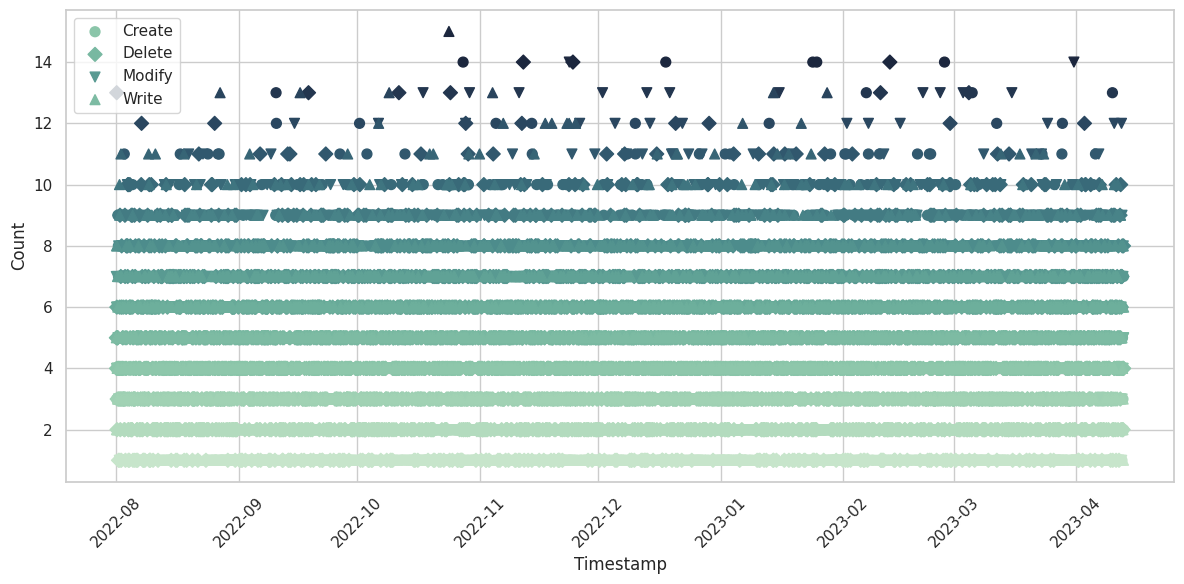

In [116]:
## Plot 01a
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Set plot style
sns.set(style='whitegrid')

# Define marker and color dictionaries for different changeType values
marker_dict = {'Create': 'o', 'Update': 's', 'Delete': 'D', 'Modify': 'v', 'Write': '^'}
color_dict = {'Create': 'red', 'Update': 'blue', 'Delete': 'green', 'Modify': 'magenta', 'Write': 'yellow'}

# Get unique changeType values
# change_types = anomalies.index.get_level_values('changeType').unique()
change_types = df_with_count.index.get_level_values('changeType').unique()

# Create a wider plot
plt.figure(figsize=(12, 6))

# Iterate through unique changeTypes and plot a scatter plot for each
for change_type in change_types:
    # sub_df = anomalies.xs(change_type, level='changeType')
    sub_df = df_with_count.xs(change_type, level='changeType')

    # Apply jitter to points
    jitter = 0.2
    x_values = sub_df.index
    y_values = sub_df['count']
    x_values_posix = x_values.astype(np.int64) // 10**9
    x_jittered_posix = x_values_posix + np.random.uniform(-jitter, jitter, size=len(x_values))
    x_jittered = pd.to_datetime(x_jittered_posix, unit='s')

    # To get distinct color use
    # colors= color_dict[change_type]
    
    # Define gradient color based on 'count' values
    cmap = sns.cubehelix_palette(rot=-.4, as_cmap=True)
    norm = plt.Normalize(y_values.min(), y_values.max())
    colors = cmap(norm(y_values))
    
    plt.scatter(
        x_jittered, y_values,
        c=colors, marker=marker_dict[change_type],
        s=50, # Adjust marker size
        label=change_type
    )

plt.xlabel('Timestamp')
plt.ylabel('Count')
plt.legend()
plt.xticks(rotation=45)  # Rotate x-axis labels
plt.tight_layout()
plt.show()


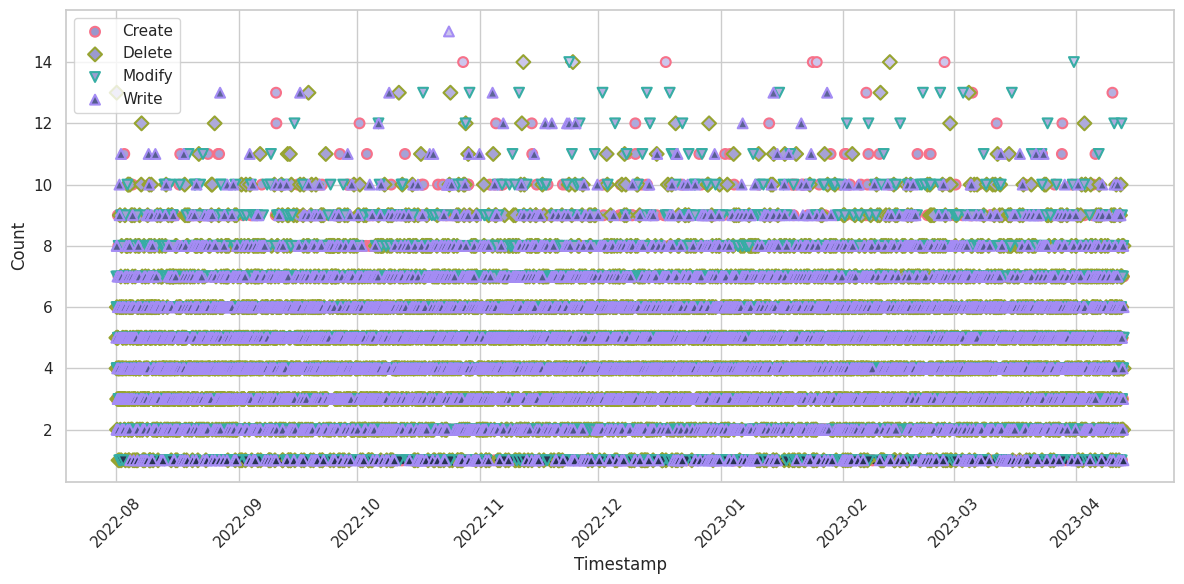

In [120]:
## Plot 01b
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# df_with_count.set_index(['timestamp', 'changeType'], inplace=True)

# Set plot style
sns.set(style='whitegrid')

# Define marker dictionary for different changeType values
marker_dict = {'Create': 'o', 'Update': 's', 'Delete': 'D', 'Modify': 'v', 'Write': '^'}

# Get unique changeType values
change_types = df_with_count.index.get_level_values('changeType').unique()

# Get a color palette with the same number of colors as unique changeTypes
color_palette = sns.color_palette('husl', n_colors=len(change_types))
color_dict = dict(zip(change_types, color_palette))

# Create a wider plot
plt.figure(figsize=(12, 6))

# Iterate through unique changeTypes and plot a scatter plot for each
for change_type in change_types:
    sub_df = df_with_count.xs(change_type, level='changeType')

    # Apply jitter to points
    jitter = 0.2
    x_values = sub_df.index
    y_values = sub_df['count']
    x_values_posix = x_values.astype(np.int64) // 10**9
    x_jittered_posix = x_values_posix + np.random.uniform(-jitter, jitter, size=len(x_values))
    x_jittered = pd.to_datetime(x_jittered_posix, unit='s')
    
    # Define gradient color based on 'count' values
    # NOTE: Change this
    cmap = sns.cubehelix_palette(start=2.8, rot=.1, dark=0.2, light=0.8, reverse=True, as_cmap=True)
    ratio = sub_df['count'] / sub_df['mean']
    norm = plt.Normalize(ratio.min(), ratio.max())
    colors = cmap(norm(ratio))
    
    plt.scatter(
        x_jittered, y_values,
        c=colors, marker=marker_dict[change_type],
        s=50, # Adjust marker size
        label=change_type,
        edgecolors=color_dict[change_type], # Set edge color
        linewidth=1.5 # Adjust edge line width
    )

plt.xlabel('Timestamp')
plt.ylabel('Count')
plt.legend()
plt.xticks(rotation=45)  # Rotate x-axis labels
plt.tight_layout()
plt.show()


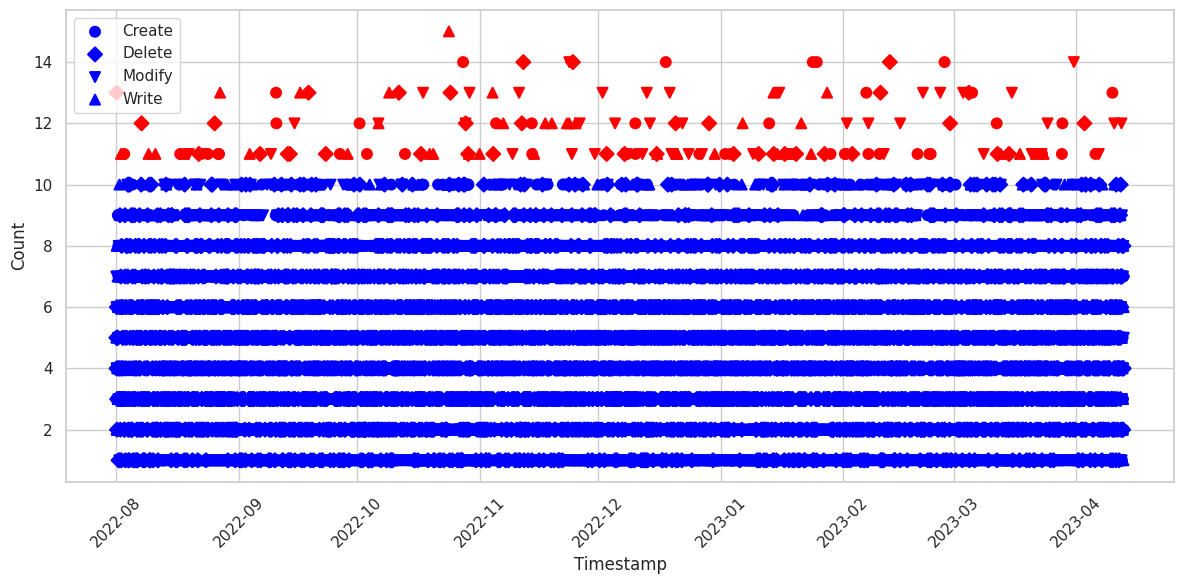

In [119]:
## Plot 01c
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# df_with_count.set_index(['timestamp', 'changeType'], inplace=True)

# Set plot style
sns.set(style='whitegrid')

# Define marker dictionary for different changeType values
marker_dict = {'Create': 'o', 'Update': 's', 'Delete': 'D', 'Modify': 'v', 'Write': '^'}

# Get unique changeType values
change_types = df_with_count.index.get_level_values('changeType').unique()

# Get a color palette with the same number of colors as unique changeTypes
color_palette = sns.color_palette('husl', n_colors=len(change_types))
color_dict = dict(zip(change_types, color_palette))

# Create a wider plot
plt.figure(figsize=(12, 6))

# Iterate through unique changeTypes and plot a scatter plot for each
for change_type in change_types:
    sub_df = df_with_count.xs(change_type, level='changeType')

    # Apply jitter to points
    jitter = 0.2
    x_values = sub_df.index
    y_values = sub_df['count']
    x_values_posix = x_values.astype(np.int64) // 10**9
    x_jittered_posix = x_values_posix + np.random.uniform(-jitter, jitter, size=len(x_values))
    x_jittered = pd.to_datetime(x_jittered_posix, unit='s')

    # Set color based on 'is_anomaly' values
    colors = ['red' if is_anomaly else 'blue' for is_anomaly in sub_df['is_anomaly']]
    
    plt.scatter(
        x_jittered, y_values,
        c=colors, marker=marker_dict[change_type],
        s=50, # Adjust marker size
        label=change_type,
        edgecolors=colors, # Set edge color
        linewidth=1.5 # Adjust edge line width
    )
    
plt.xlabel('Timestamp')
plt.ylabel('Count')
plt.legend()
plt.xticks(rotation=45)  # Rotate x-axis labels
plt.tight_layout()
plt.show()


In [122]:
# df_with_count.index.get_level_values('timestamp')
df_with_count

,,hour,day,day_of_week,changeType_encoded,count,rolling_avg,sin_1,cos_1,sin_2,cos_2,sin_weekly_1,cos_weekly_1,sin_weekly_2,cos_weekly_2,is_anomaly_m2,is_anomaly,anomaly_score,predicted_count,residuals,mean
timestamp,changeType,,,,,,,,,,,,,,,,,,,,
2022-08-01 01:00:00,Create,1,1,1,1,4,4.000000,0.258819,0.965926,0.500000,8.660254e-01,0.037391,0.999301,0.074730,9.972038e-01,1,False,0.283019,4.000000,-4.768372e-07,4.000000
2022-08-01 02:00:00,Create,2,1,1,1,3,3.500000,0.500000,0.866025,0.866025,5.000000e-01,0.074730,0.997204,0.149042,9.888308e-01,1,False,0.283019,3.000006,-5.960464e-06,3.000006
2022-08-01 03:00:00,Create,3,1,1,1,5,4.000000,0.707107,0.707107,1.000000,6.123234e-17,0.111964,0.993712,0.222521,9.749279e-01,1,False,0.283019,4.999998,2.384186e-06,4.999998
2022-08-01 04:00:00,Create,4,1,1,1,6,4.500000,0.866025,0.500000,0.866025,-5.000000e-01,0.149042,0.988831,0.294755,9.555728e-01,1,False,0.283019,5.999995,4.768372e-06,5.999995
2022-08-01 05:00:00,Create,5,1,1,1,5,4.600000,0.965926,0.258819,0.500000,-8.660254e-01,0.185912,0.982566,0.365341,9.308737e-01,1,False,0.283019,4.999998,2.384186e-06,4.999998
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-04-12 19:00:00,Write,19,12,3,4,2,4.500000,-0.965926,0.258819,-0.500000,-8.660254e-01,0.652287,0.757972,0.988831,1.490423e-01,1,False,0.283019,2.000009,-9.059906e-06,2.000009
2023-04-12 20:00:00,Write,20,12,3,4,3,4.166667,-0.866025,0.500000,-0.866025,-5.000000e-01,0.680173,0.733052,0.997204,7.473009e-02,1,False,0.283019,3.000006,-5.960464e-06,3.000006
2023-04-12 21:00:00,Write,21,12,3,4,8,4.500000,-0.707107,0.707107,-1.000000,-4.286264e-16,0.707107,0.707107,1.000000,6.123234e-17,1,False,0.283019,7.999993,7.152557e-06,7.999993


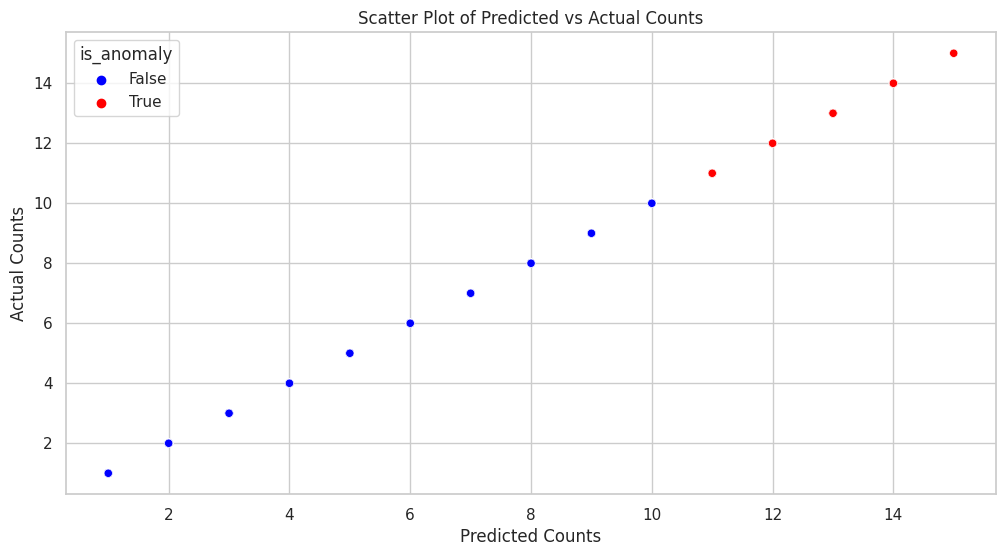

In [121]:
## Plot 02 - make a scatter plot of actual vs predicted counts

import matplotlib.pyplot as plt
import seaborn as sns

# Set plot style
sns.set(style='whitegrid')

# Create a wider plot
plt.figure(figsize=(12, 6))

# Scatter plot of predicted vs actual counts
sns.scatterplot(x=df_with_count['mean'], y=df_with_count['count'], hue=df_with_count['is_anomaly'], palette=['blue', 'red'])

plt.xlabel('Predicted Counts')
plt.ylabel('Actual Counts')
plt.title('Scatter Plot of Predicted vs Actual Counts')

plt.show()

## TODO: can we also have a residual plot?



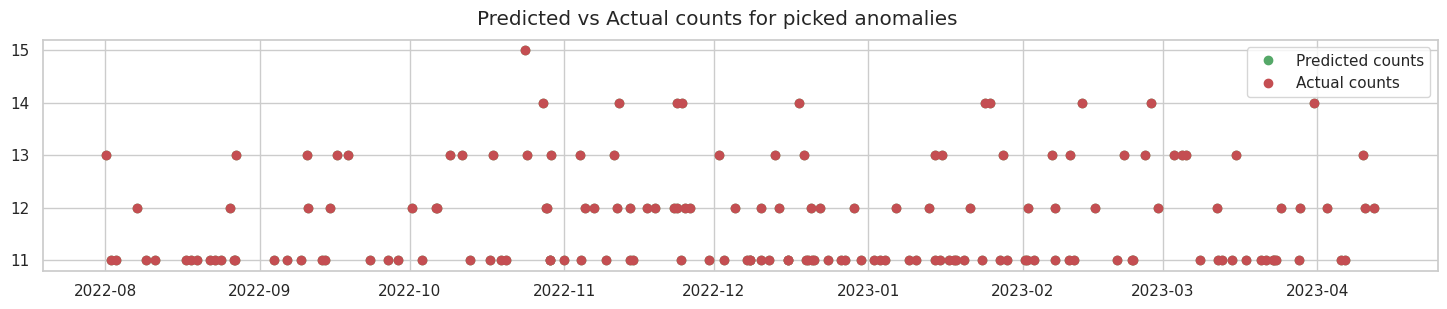

In [123]:
## Plot 03 - plot only the anamolous data points
## NOTE: Continue VISUALIZATION
## Let's plot only picked anomalies (the actual vs predicted count)
anomalies = df_with_count[df_with_count['is_anomaly'] == True]
anomalies = anomalies.copy()
anomalies.sort_index(level='timestamp', inplace=True)

fig = plt.figure(figsize=(18, 3))
fig.suptitle("Predicted vs Actual counts for picked anomalies")
predicted, = plt.plot(anomalies.index.get_level_values('timestamp'), anomalies['mean'], 'go', linestyle='none', label='Predicted counts')
actual, = plt.plot(anomalies.index.get_level_values('timestamp'), anomalies['count'], 'ro', linestyle='none', label='Actual counts')
plt.legend(handles=[predicted, actual])
plt.show()


In [126]:
anomalies

,,hour,day,day_of_week,changeType_encoded,count,rolling_avg,sin_1,cos_1,sin_2,cos_2,sin_weekly_1,cos_weekly_1,sin_weekly_2,cos_weekly_2,is_anomaly_m2,is_anomaly,anomaly_score,predicted_count,residuals,mean
timestamp,changeType,,,,,,,,,,,,,,,,,,,,
2022-08-01 03:00:00,Delete,3,1,1,2,13,7.333333,0.707107,0.707107,1.000000,6.123234e-17,0.111964,0.993712,0.222521,0.974928,-1,True,0.283019,12.999902,0.000098,12.999902
2022-08-02 05:00:00,Write,5,2,2,4,11,5.833333,0.965926,0.258819,0.500000,-8.660254e-01,0.185912,0.982566,0.365341,0.930874,1,True,0.283019,10.999965,0.000035,10.999965
2022-08-03 01:00:00,Create,1,3,3,1,11,7.000000,0.258819,0.965926,0.500000,8.660254e-01,0.037391,0.999301,0.074730,0.997204,-1,True,0.283019,10.999965,0.000035,10.999965
2022-08-07 10:00:00,Delete,10,7,7,2,12,6.833333,0.500000,-0.866025,-0.866025,5.000000e-01,0.365341,0.930874,0.680173,0.733052,1,True,0.283019,11.999934,0.000066,11.999934
2022-08-09 05:00:00,Write,5,9,2,4,11,6.166667,0.965926,0.258819,0.500000,-8.660254e-01,0.185912,0.982566,0.365341,0.930874,1,True,0.283019,10.999965,0.000035,10.999965
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-04-05 20:00:00,Create,20,5,3,1,11,6.500000,-0.866025,0.500000,-0.866025,-5.000000e-01,0.680173,0.733052,0.997204,0.074730,1,True,0.283019,10.999965,0.000035,10.999965
2023-04-06 16:00:00,Modify,16,6,4,3,11,5.500000,-0.866025,-0.500000,0.866025,-5.000000e-01,0.563320,0.826239,0.930874,0.365341,1,True,0.283019,10.999965,0.000035,10.999965
2023-04-10 03:00:00,Create,3,10,1,1,13,6.833333,0.707107,0.707107,1.000000,6.123234e-17,0.111964,0.993712,0.222521,0.974928,-1,True,0.283019,12.999902,0.000098,12.999902


In [127]:
# ## TODO : now for the time-stamp and changeType that we have picked as anomolous,
# Now, let's look back at the original data before we floored the data by hour, 
# and see which individual observations are making values in this particular timestamp anomolous.

# YES

# Create an empty DataFrame to store the anomalous records
# df_anomalous_records = pd.DataFrame()
df_anomalous_records = []

# Loop over the anomalous timestamps and changeTypes
# for timestamp, changeType in zip(anomalous_timestamps, anomalous_changeTypes):
for ts, ct in anomalies.index:
    # print(ts, ct)

    # Round the timestamp to the nearest hour
    # timestamp = timestamp.floor('H')
    ts = ts.floor('H')
    
    # Get the records from the original DataFrame that match the timestamp and changeType
    # anomalous_records = df_original[(df_original['timestamp'].dt.floor('H') == timestamp) & (df_original['changeType'] == changeType)]
    anomalous_records = df_original[(df_original['timestamp'].dt.floor('H') == ts) & (df_original['changeType'] == ct)]

    # Append the records to df_anomalous_records
    # df_anomalous_records = df_anomalous_records.append(anomalous_records) ## NOTE: not working on new pandas
    df_anomalous_records.append(anomalous_records)
    
# Now df_anomalous_records contains the records from the original dataset that contributed to the anomalies
# merge the list of dataframes
merged_df = pd.concat(df_anomalous_records)
# merged_df


In [128]:
## NOTE: So, in this example we have about 7148 records that were anomalous out of 100k records
merged_df

## Now, among this anomaly we can pick further dissect and pick our anomaly of interest
# and also probably try to explain why they were anomolous

#NOTE: if the threshold was higher, then the picked anomaly would be less


,changeType,timestamp
21185,Delete,2022-08-01 03:22:50
39277,Delete,2022-08-01 03:57:09
44632,Delete,2022-08-01 03:04:13
44891,Delete,2022-08-01 03:26:28
47470,Delete,2022-08-01 03:05:47
...,...,...
66921,Modify,2023-04-12 10:45:17
72262,Modify,2023-04-12 10:06:13
72950,Modify,2023-04-12 10:15:32
83647,Modify,2023-04-12 10:26:05


In [28]:
## TODO: Continue - Track the Std-Dev
## Use this example - https://towardsdatascience.com/anomaly-detection-in-time-series-sensor-data-86fd52e62538 
## TODO: PLOT - which time windows were anomalous, which changeType were anomolous during this time-window.

## some other plots from here too
  # https://journalofbigdata.springeropen.com/articles/10.1186/s40537-014-0011-y 
  # make an anomaly band at the top and bottom 

# df_original

,changeType,timestamp
0,Delete,2023-04-02 02:00:01
1,Modify,2023-01-01 15:27:14
2,Modify,2023-03-02 01:32:24
3,Delete,2022-08-30 23:45:10
4,Modify,2023-04-06 02:56:53
...,...,...
99995,Modify,2023-02-20 23:10:24
99996,Delete,2022-09-16 04:07:28
99997,Delete,2022-09-21 04:31:53
99998,Write,2022-09-10 06:19:04


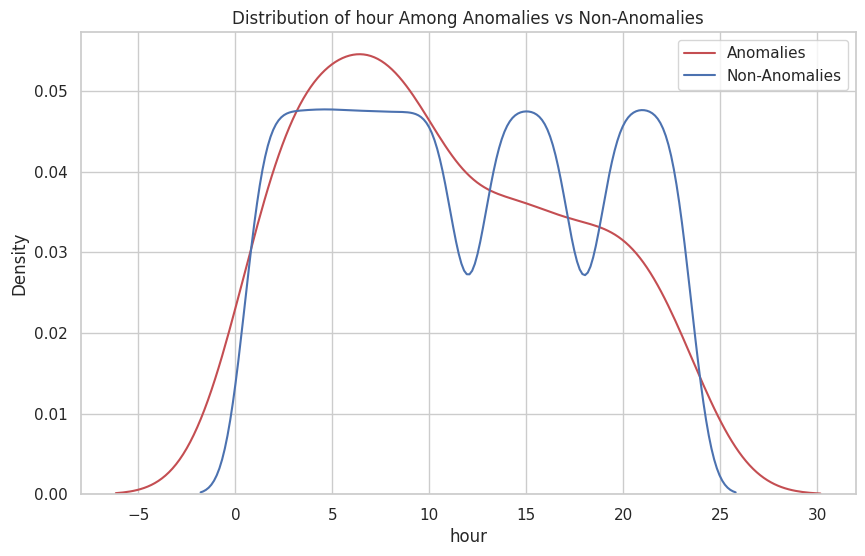

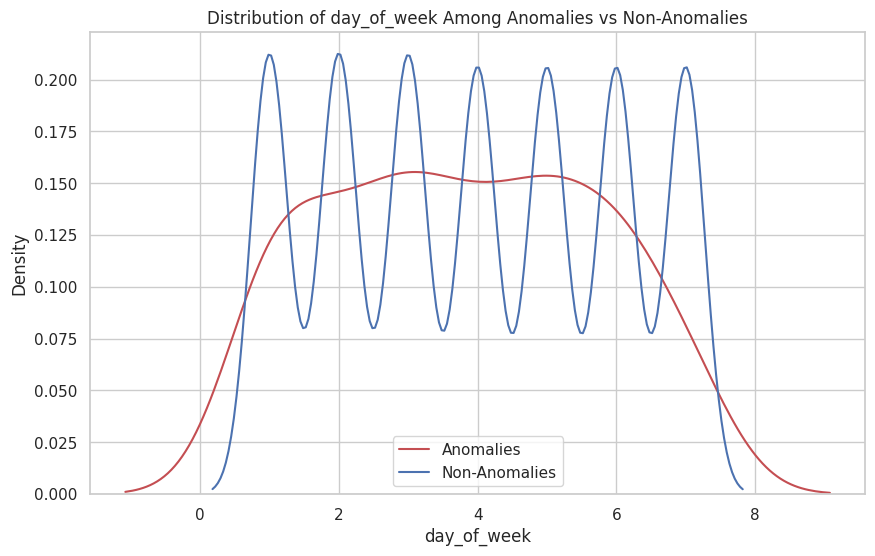

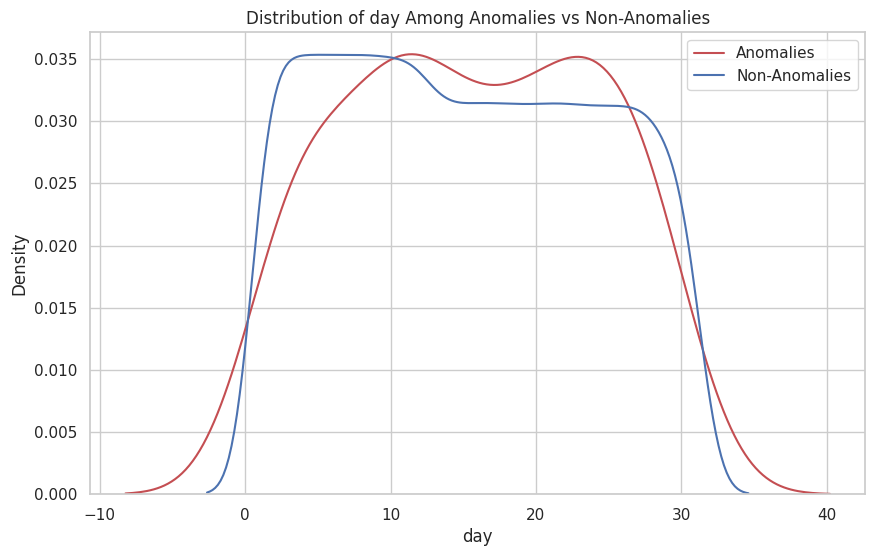

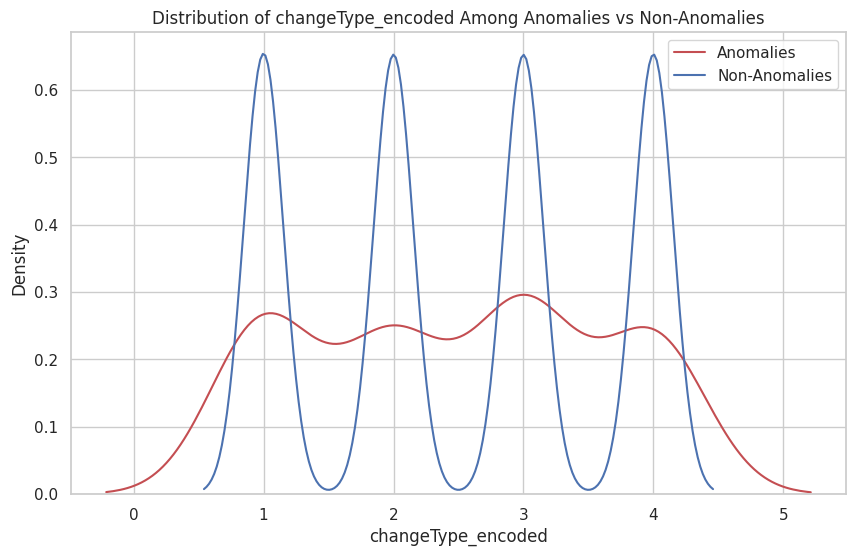

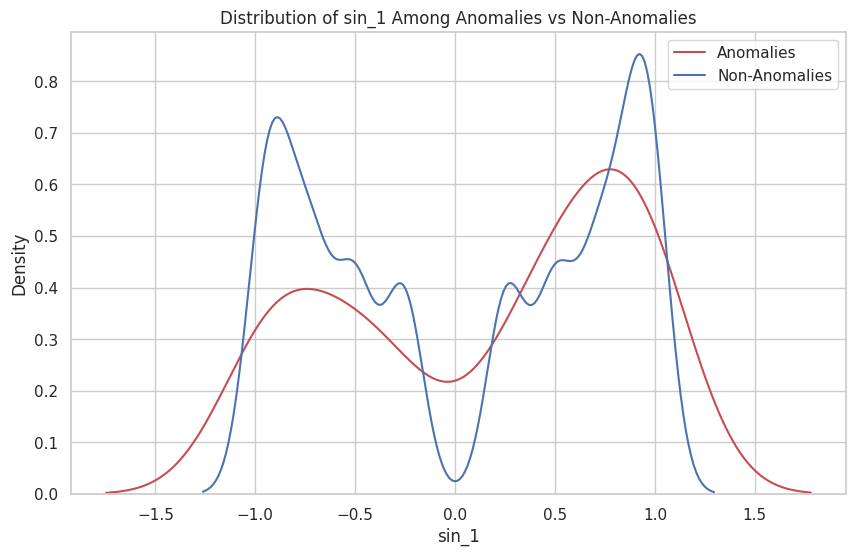

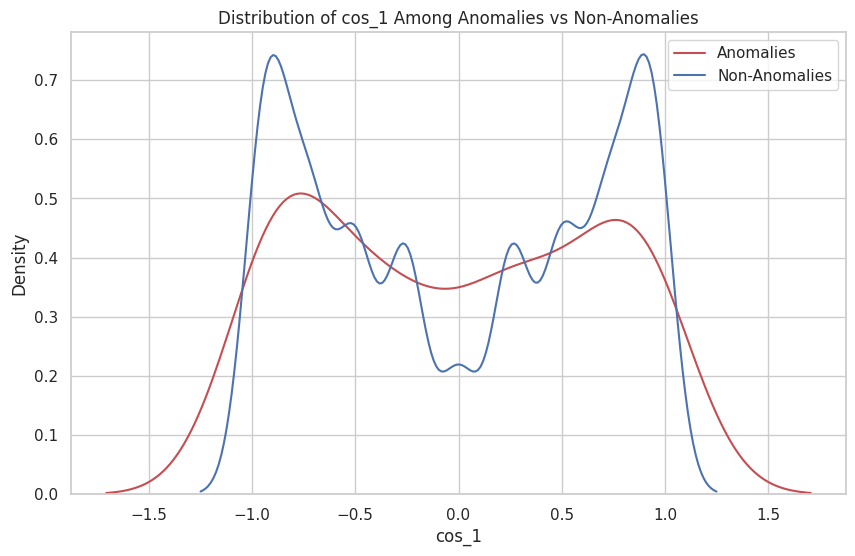

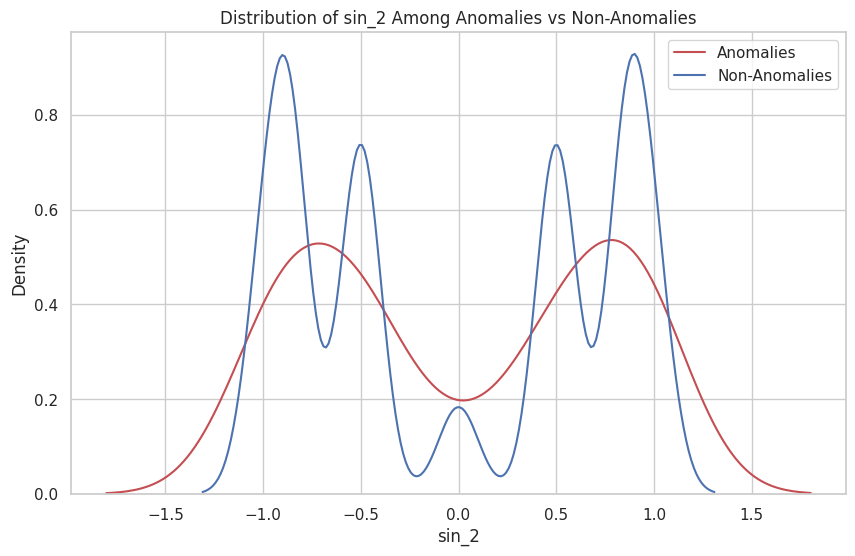

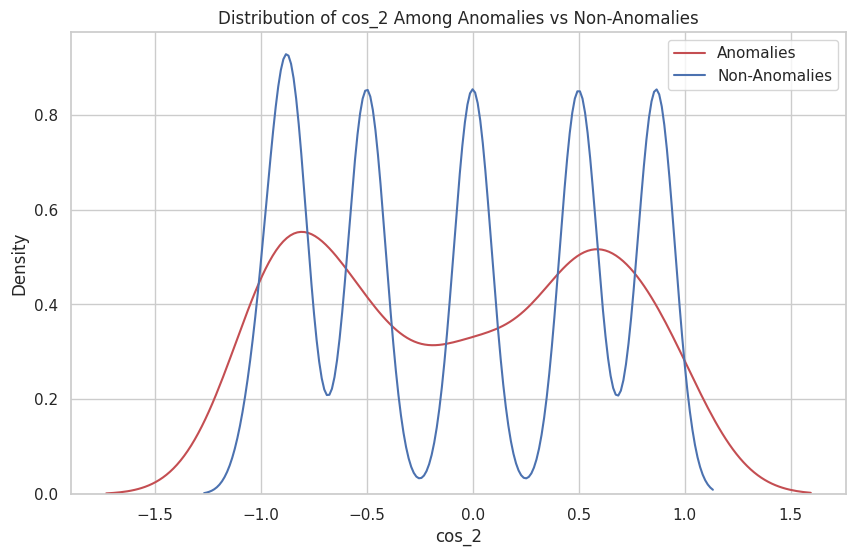

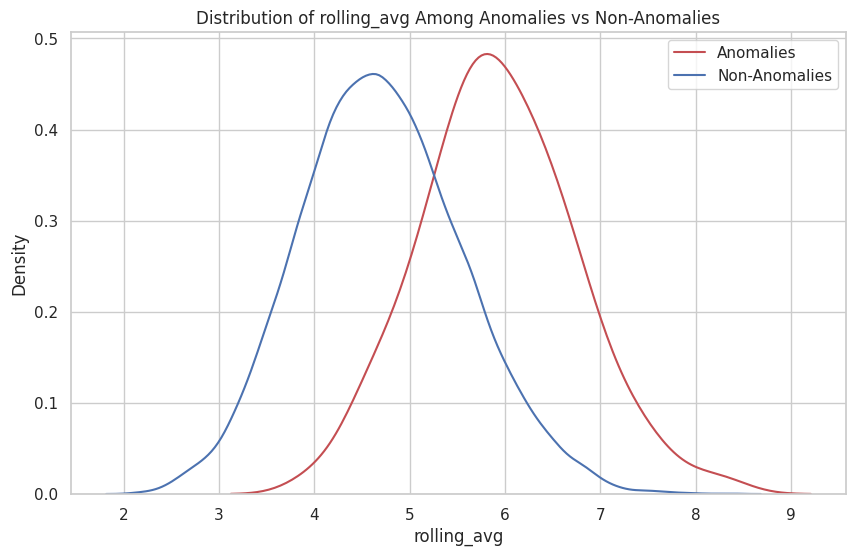

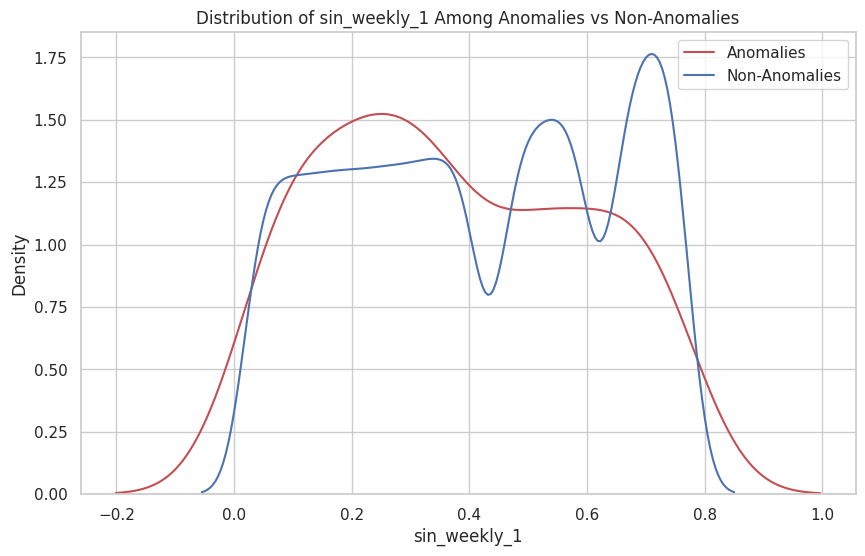

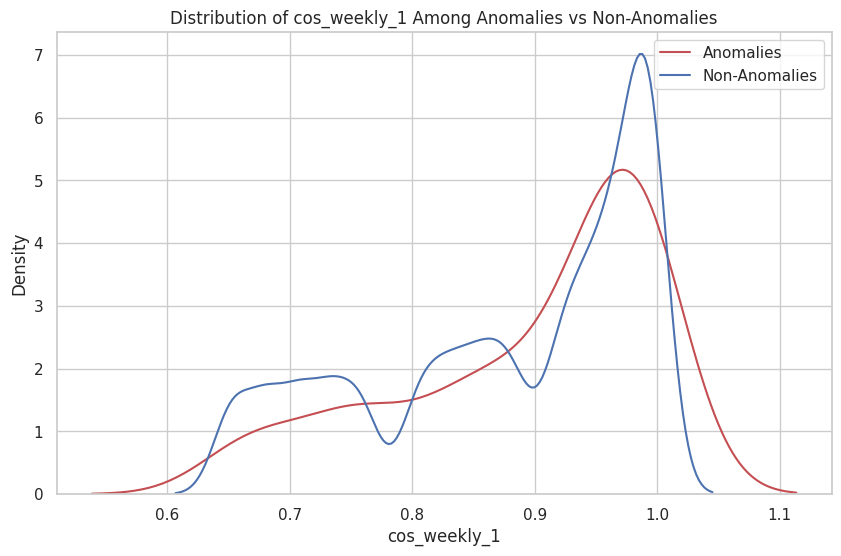

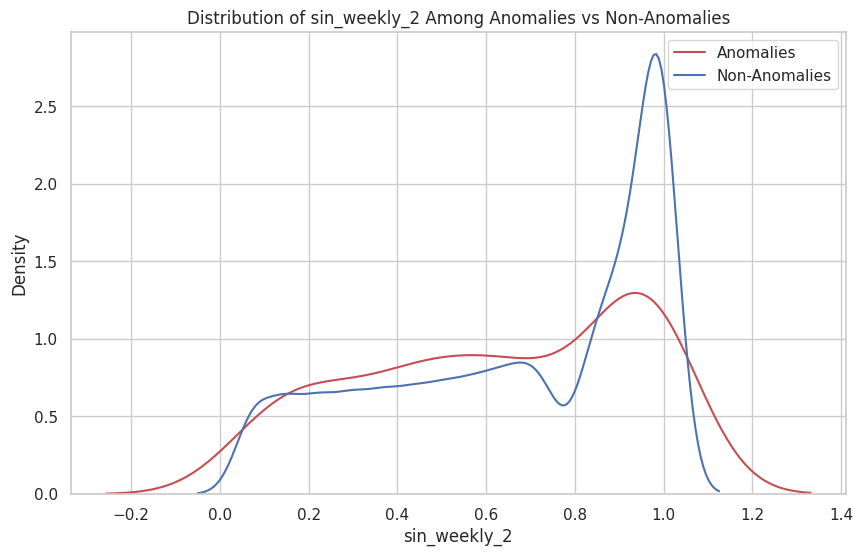

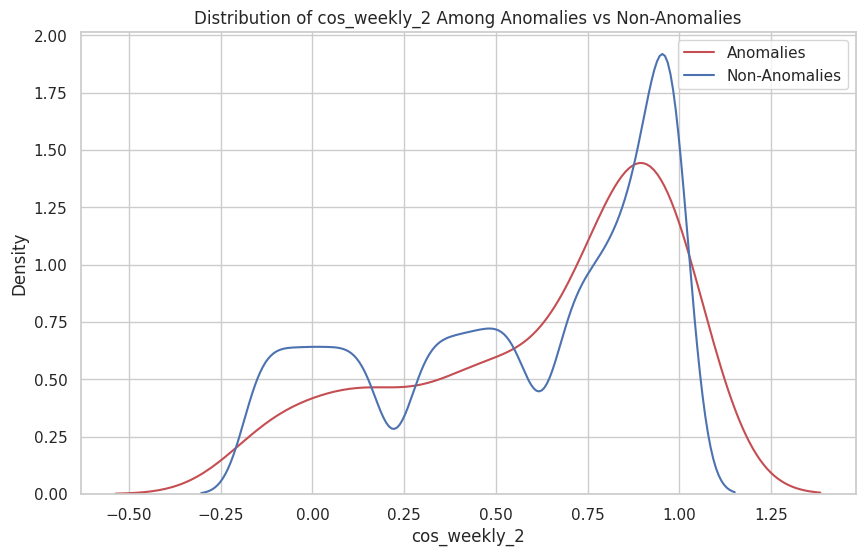

In [129]:
## NOTE: Continue
## More VISUALIZATION
## let's try to identify which features were important in labelling a particular row (or observation) as anomolous
import matplotlib.pyplot as plt
import seaborn as sns

anomalies = df_with_count[df_with_count['is_anomaly'] == True]
non_anomalies = df_with_count[df_with_count['is_anomaly'] == False]

## reset the changeType (sub-index) as a column
# When you have multiple index 
# Specify which index you wanted to set to column
# anomalies.reset_index(inplace=True, level=['changeType'])
# non_anomalies.reset_index(inplace=True, level=['changeType'])

# Preserve Index as-is and add one index as column
# Using assign operator.
# anomalies['changeType'] = anomalies.index.get_level_values('changeType')
# non_anomalies['changeType'] = non_anomalies.index.get_level_values('changeType')


# List of features
# features = ['hour', 'day_of_week', 'day', 'changeType', 'sin_1', 'cos_1', 'sin_2', 'cos_2']
# features = ['hour', 'day_of_week', 'day', 'changeType_encoded', 'sin_1', 'cos_1', 'sin_2', 'cos_2']
features = ['hour', 'day_of_week', 'day', 'changeType_encoded', 
            'sin_1', 'cos_1', 'sin_2', 'cos_2', 'rolling_avg', 
            'sin_weekly_1', 'cos_weekly_1', 'sin_weekly_2', 'cos_weekly_2']



for feature in features:
    plt.figure(figsize=(10, 6))

    sns.kdeplot(anomalies[feature], label='Anomalies', color='r')
    sns.kdeplot(non_anomalies[feature], label='Non-Anomalies', color='b')

    plt.title(f'Distribution of {feature} Among Anomalies vs Non-Anomalies')
    plt.legend()
    plt.show()



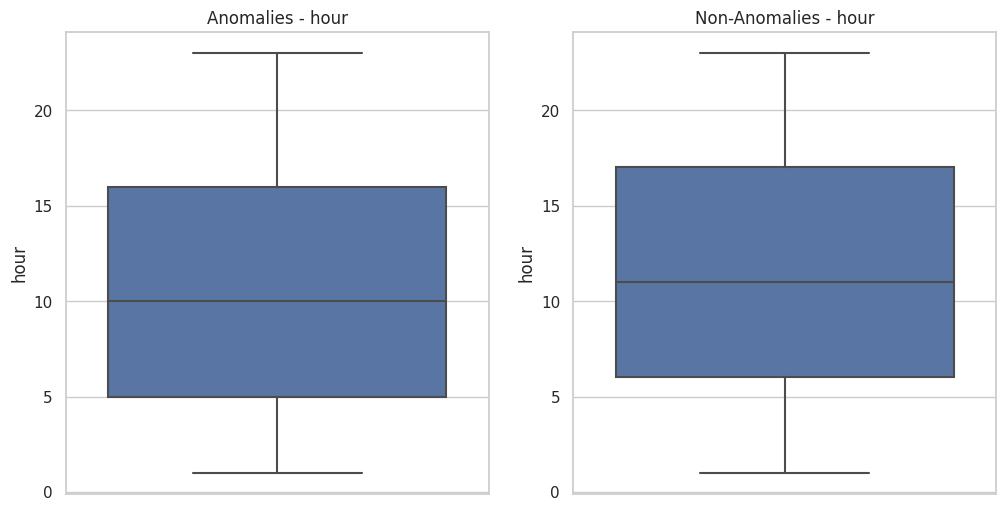

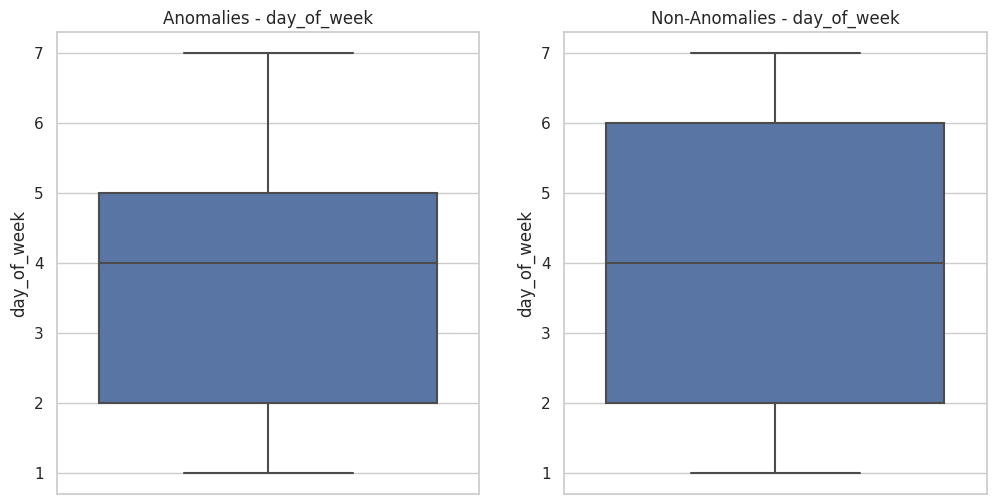

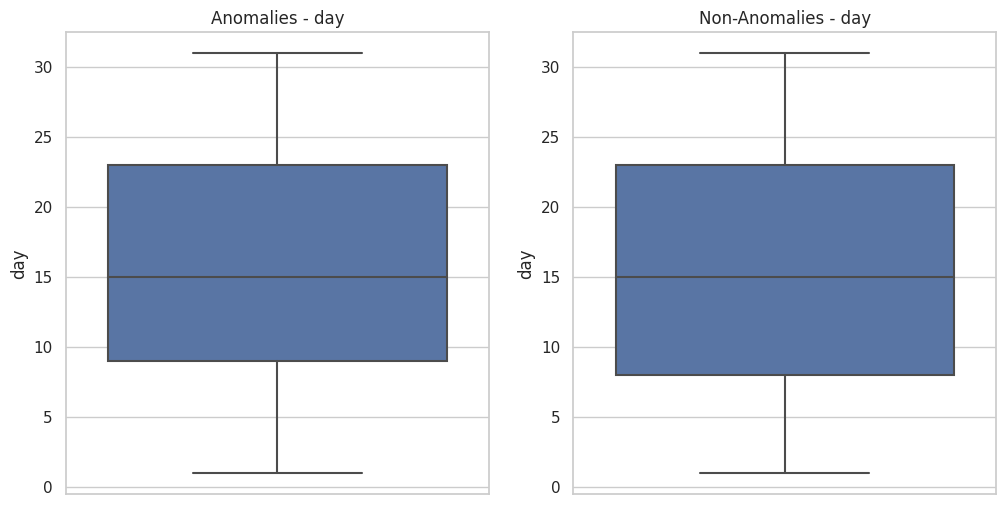

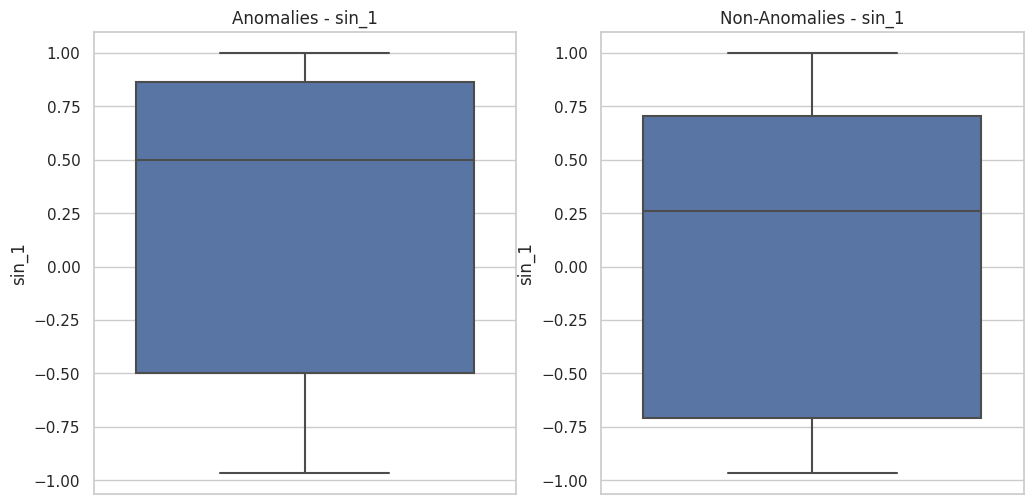

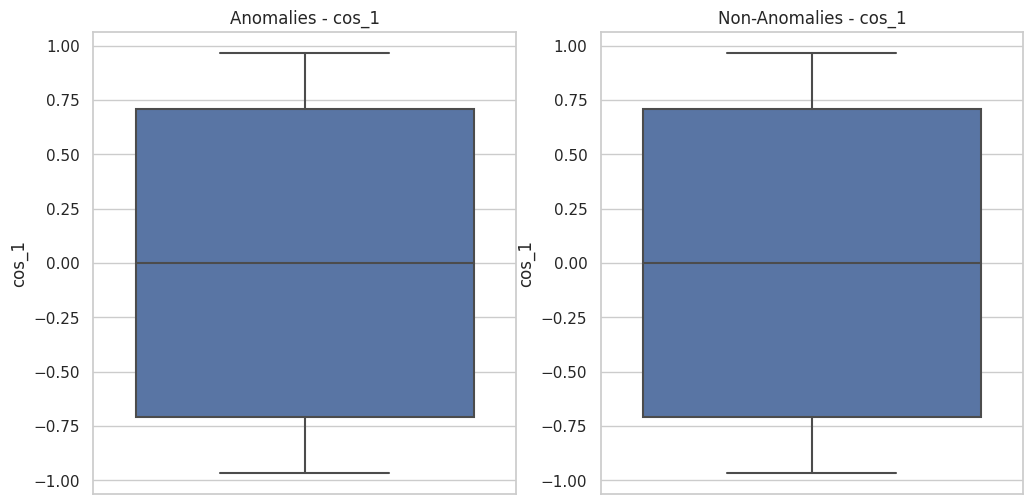

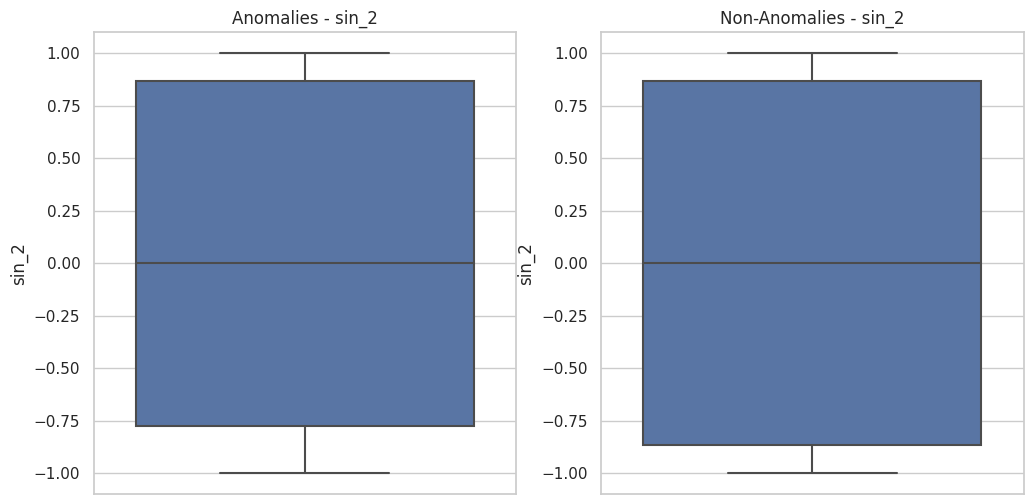

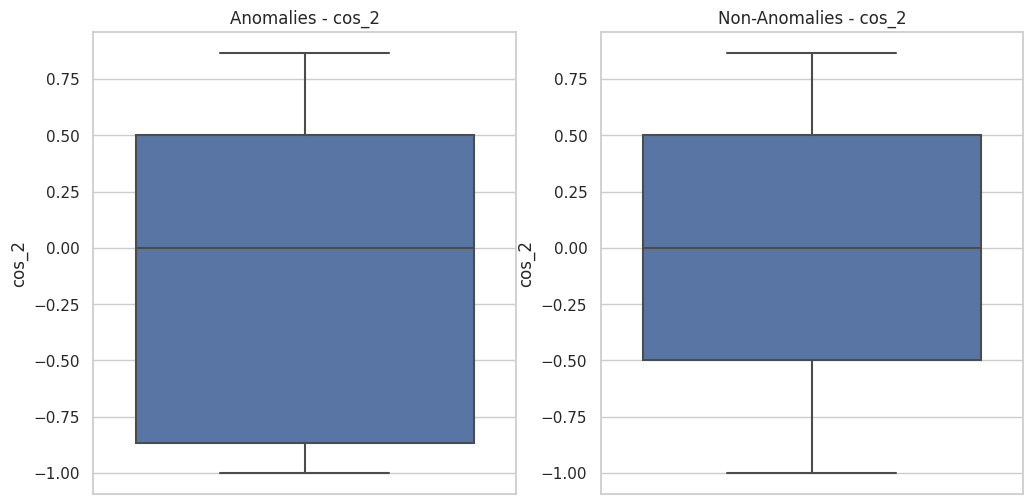

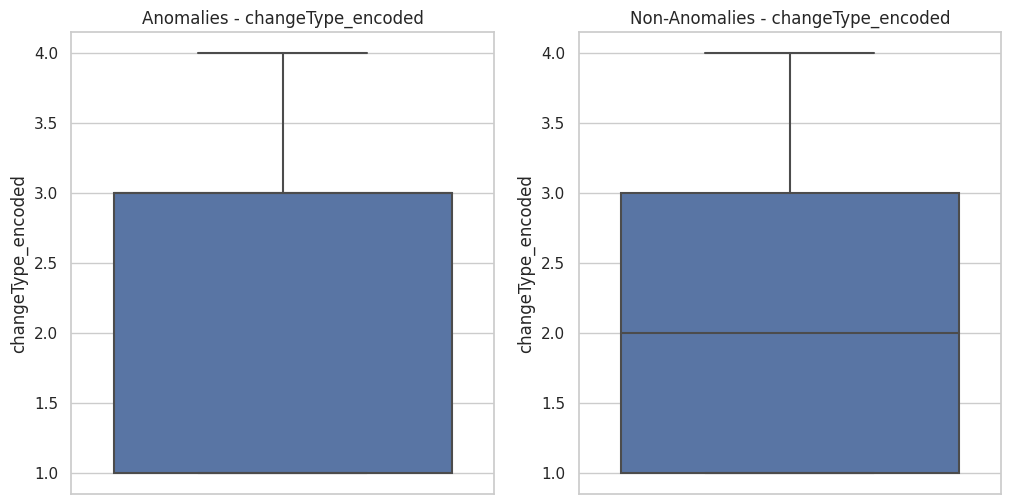

In [130]:
# To visualize the contribution of each feature in distinguishing anomalies from non-anomalies, we can plot the distributions of each feature for the anomaly and non-anomaly classes side by side. This can give us an idea of which features have significantly different distributions for anomalies compared to non-anomalies.

# Here's a simple way to do this using boxplots, which show the median, quartiles, and potential outliers for each distribution:

import matplotlib.pyplot as plt
import seaborn as sns

# features = ['hour', 'day_of_week', 'day', 'sin_1', 'cos_1', 'sin_2', 'cos_2', 'changeType']
features = ['hour', 'day_of_week', 'day', 'sin_1', 'cos_1', 'sin_2', 'cos_2', 'changeType_encoded']


anomalies = df_with_count[df_with_count['is_anomaly'] == True]
non_anomalies = df_with_count[df_with_count['is_anomaly'] == False]

for feature in features:
    plt.figure(figsize=(12, 6))

    plt.subplot(1, 2, 1)
    sns.boxplot(y=anomalies[feature])
    plt.title(f'Anomalies - {feature}')

    plt.subplot(1, 2, 2)
    sns.boxplot(y=non_anomalies[feature])
    plt.title(f'Non-Anomalies - {feature}')

    plt.show()


/mnt/d/GitProjects/Project_Anomaly_Detection/.wslenv01/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


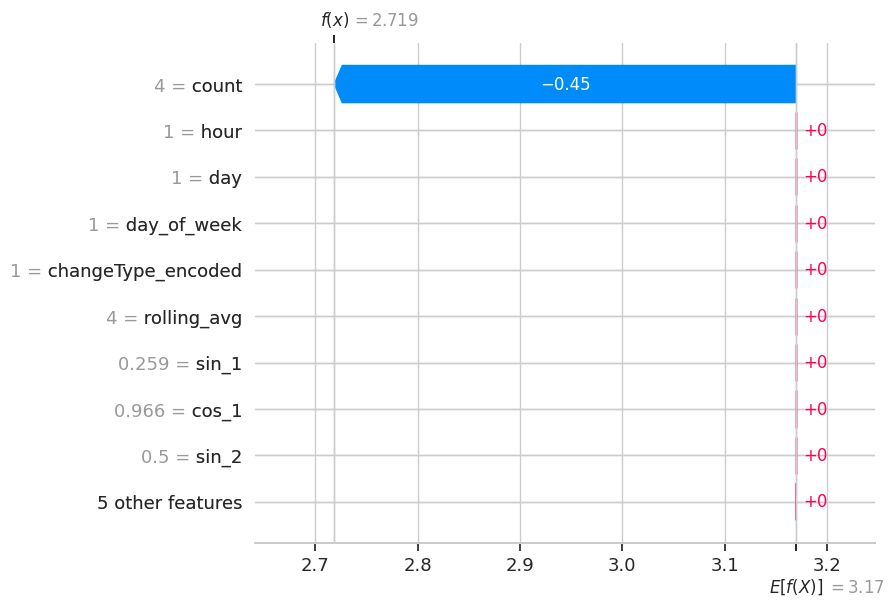

In [131]:
## TODO: Continue ... 
# NOTE: IGNORE for now

# For a more precise understanding of how each feature contributes to the prediction for a 
# specific instance, you might use something like the SHAP library. 
# However, as I mentioned earlier, this would require a machine learning model that supports SHAP values, like XGBoost, LightGBM, or a neural network. 
# The GLM model you're using now doesn't directly support SHAP values.
# Here's an example of how you might use SHAP with an XGBoost model:

import xgboost as xgb
import shap

# train XGBoost model
model = xgb.train({"learning_rate": 0.01}, xgb.DMatrix(X, label=y), 100)

# explain the model's predictions using SHAP
explainer = shap.Explainer(model)
shap_values = explainer(X)

# visualize the first prediction's explanation
shap.plots.waterfall(shap_values[0])


Modelling (03) using Isolation Forest ECOD


In [49]:
df_with_count_cp

,changeType,timestamp,hour,day,day_of_week,changeType_encoded,count,rolling_avg,sin_1,cos_1,sin_2,cos_2,sin_weekly_1,cos_weekly_1,sin_weekly_2,cos_weekly_2,scaled_count,is_anomaly
0,Create,2022-08-01 01:00:00,1,1,1,1,4,4.000000,0.258819,0.965926,0.500000,8.660254e-01,0.037391,0.999301,0.074730,9.972038e-01,-0.336525,1
1,Create,2022-08-01 02:00:00,2,1,1,1,3,3.500000,0.500000,0.866025,0.866025,5.000000e-01,0.074730,0.997204,0.149042,9.888308e-01,-0.808083,1
2,Create,2022-08-01 03:00:00,3,1,1,1,5,4.000000,0.707107,0.707107,1.000000,6.123234e-17,0.111964,0.993712,0.222521,9.749279e-01,0.135032,1
3,Create,2022-08-01 04:00:00,4,1,1,1,6,4.500000,0.866025,0.500000,0.866025,-5.000000e-01,0.149042,0.988831,0.294755,9.555728e-01,0.606590,1
4,Create,2022-08-01 05:00:00,5,1,1,1,5,4.600000,0.965926,0.258819,0.500000,-8.660254e-01,0.185912,0.982566,0.365341,9.308737e-01,0.135032,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21210,Write,2023-04-12 19:00:00,19,12,3,4,2,4.500000,-0.965926,0.258819,-0.500000,-8.660254e-01,0.652287,0.757972,0.988831,1.490423e-01,-1.279641,1
21211,Write,2023-04-12 20:00:00,20,12,3,4,3,4.166667,-0.866025,0.500000,-0.866025,-5.000000e-01,0.680173,0.733052,0.997204,7.473009e-02,-0.808083,1
21212,Write,2023-04-12 21:00:00,21,12,3,4,8,4.500000,-0.707107,0.707107,-1.000000,-4.286264e-16,0.707107,0.707107,1.000000,6.123234e-17,1.549706,1
21213,Write,2023-04-12 22:00:00,22,12,3,4,1,4.333333,-0.500000,0.866025,-0.866025,5.000000e-01,0.733052,0.680173,0.997204,-7.473009e-02,-1.751199,1


In [96]:
# Assuming df is your DataFrame and "scaled_count", "hour", "day", "changeType_encoded", etc. are columns

from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import StandardScaler

# Standardize the data (important for distance-based models)
scaler = StandardScaler()
variables = ['hour', 'day', 'day_of_week', 'changeType_encoded', 'count', 
    'rolling_avg', 'sin_1', 'cos_1', 'sin_2', 'cos_2', 
    'sin_weekly_1', 'cos_weekly_1', 'sin_weekly_2', 'cos_weekly_2']
# df_with_count_cp[variables] = scaler.fit_transform(df_with_count_cp[variables])


# Reshape your data
# X = df_with_count_cp[variables]
X = pd.DataFrame()
# X[variables] = scaler.fit_transform(df_with_count_cp[variables])
X[variables] = scaler.fit_transform(df_with_count[variables])


# Create an Isolation Forest model
clf = IsolationForest(contamination=0.01, random_state=42)  # adjust contamination as needed

# Fit the model
clf.fit(X)

# Predict the anomalies in the data
# df_with_count_cp['is_anomaly_m2'] = clf.predict(X)
# df_with_count['is_anomaly'] = clf.predict(X)
df_with_count['anomaly_score'] = clf.decision_function(X)

df_with_count['is_anomaly'] = clf.predict(X) == -1

# The model will predict -1 for anomalies and 1 for normal data points.


/mnt/d/GitProjects/Project_Anomaly_Detection/.wslenv01/lib/python3.10/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(


In [99]:
df_with_count
df_with_count[df_with_count['is_anomaly'] == True]

# df_with_count_cp = df_with_count.copy()
# df_with_count_cp
# df_with_count_cp[df_with_count_cp['is_anomaly'] != 1]
# df_with_count_cp[df_with_count_cp['is_anomaly_m2'] != 1]

# X

,,hour,day,day_of_week,changeType_encoded,count,rolling_avg,sin_1,cos_1,sin_2,cos_2,sin_weekly_1,cos_weekly_1,sin_weekly_2,cos_weekly_2,is_anomaly_m2,is_anomaly,anomaly_score
timestamp,changeType,,,,,,,,,,,,,,,,,
2022-08-02 23:00:00,Create,23,2,2,1,8,6.166667,-0.258819,0.965926,-0.5,0.866025,0.757972,0.652287,0.988831,-0.149042,-1,True,-0.019508
2022-08-03 01:00:00,Create,1,3,3,1,11,7.000000,0.258819,0.965926,0.5,0.866025,0.037391,0.999301,0.074730,0.997204,-1,True,-0.022895
2022-08-07 01:00:00,Create,1,7,7,1,2,3.500000,0.258819,0.965926,0.5,0.866025,0.037391,0.999301,0.074730,0.997204,-1,True,-0.000712
2022-08-16 01:00:00,Create,1,16,2,1,9,6.000000,0.258819,0.965926,0.5,0.866025,0.037391,0.999301,0.074730,0.997204,1,True,-0.004267
2022-08-16 23:00:00,Create,23,16,2,1,10,6.166667,-0.258819,0.965926,-0.5,0.866025,0.757972,0.652287,0.988831,-0.149042,-1,True,-0.017200
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-03-19 23:00:00,Write,23,19,7,4,3,6.333333,-0.258819,0.965926,-0.5,0.866025,0.757972,0.652287,0.988831,-0.149042,1,True,-0.000976
2023-03-23 23:00:00,Write,23,23,4,4,8,6.500000,-0.258819,0.965926,-0.5,0.866025,0.757972,0.652287,0.988831,-0.149042,1,True,-0.004713
2023-03-25 01:00:00,Write,1,25,6,4,2,2.500000,0.258819,0.965926,0.5,0.866025,0.037391,0.999301,0.074730,0.997204,-1,True,-0.002652


Modeling 04 - using PYOD - ECOD

In [100]:
from pyod.models.ecod import ECOD
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler


# Define the columns to be used in the model
variables = ['hour', 'day', 'day_of_week', 'changeType_encoded', 'count', 
    'rolling_avg', 'sin_1', 'cos_1', 'sin_2', 'cos_2', 
    'sin_weekly_1', 'cos_weekly_1', 'sin_weekly_2', 'cos_weekly_2']

# Standardize the data (important for distance-based models)
scaler = StandardScaler()
X = pd.DataFrame()
X[variables] = scaler.fit_transform(df_with_count[variables])

# Initialize the ECOD model
ecod_model = ECOD(contamination=0.01)  # adjust contamination as needed

# Fit the model to your data
ecod_model.fit(X)

# Predict the anomalies in the data
df_with_count['is_anomaly'] = ecod_model.predict(X)

# Convert prediction to boolean
df_with_count['is_anomaly'] = df_with_count['is_anomaly'].astype(bool)

## Get aomaly score
df_with_count['anomaly_score'] = ecod_model.decision_function(X)


# # Calculate anomaly scores (within range 0-1)
# anomaly_scores = ecod_model.decision_function(X)

# # Scale scores to be between 0 and 1
# scaler = MinMaxScaler()
# df_with_count['anomaly_score'] = scaler.fit_transform(anomaly_scores.reshape(-1,1))
## NOTE: However, keep in mind that the raw anomaly scores can be more informative than the scaled scores 
    # as they provide a measure of the degree of anomalousness.


df_with_count

,,hour,day,day_of_week,changeType_encoded,count,rolling_avg,sin_1,cos_1,sin_2,cos_2,sin_weekly_1,cos_weekly_1,sin_weekly_2,cos_weekly_2,is_anomaly_m2,is_anomaly,anomaly_score
timestamp,changeType,,,,,,,,,,,,,,,,,
2022-08-01 01:00:00,Create,1,1,1,1,4,4.000000,0.258819,0.965926,0.500000,8.660254e-01,0.037391,0.999301,0.074730,9.972038e-01,1,True,31.607503
2022-08-01 02:00:00,Create,2,1,1,1,3,3.500000,0.500000,0.866025,0.866025,5.000000e-01,0.074730,0.997204,0.149042,9.888308e-01,1,False,27.331050
2022-08-01 03:00:00,Create,3,1,1,1,5,4.000000,0.707107,0.707107,1.000000,6.123234e-17,0.111964,0.993712,0.222521,9.749279e-01,1,False,24.150514
2022-08-01 04:00:00,Create,4,1,1,1,6,4.500000,0.866025,0.500000,0.866025,-5.000000e-01,0.149042,0.988831,0.294755,9.555728e-01,1,False,21.651396
2022-08-01 05:00:00,Create,5,1,1,1,5,4.600000,0.965926,0.258819,0.500000,-8.660254e-01,0.185912,0.982566,0.365341,9.308737e-01,1,False,20.373299
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-04-12 19:00:00,Write,19,12,3,4,2,4.500000,-0.965926,0.258819,-0.500000,-8.660254e-01,0.652287,0.757972,0.988831,1.490423e-01,1,False,19.139806
2023-04-12 20:00:00,Write,20,12,3,4,3,4.166667,-0.866025,0.500000,-0.866025,-5.000000e-01,0.680173,0.733052,0.997204,7.473009e-02,1,False,19.330462
2023-04-12 21:00:00,Write,21,12,3,4,8,4.500000,-0.707107,0.707107,-1.000000,-4.286264e-16,0.707107,0.707107,1.000000,6.123234e-17,1,False,22.729326


Modeling 05 - using PYOD - Random Forest Regressor

In [112]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

# Assuming df_with_count is your DataFrame and you have the same variables as before

# Rescale your data
X = df_with_count[variables]
y = df_with_count['count']

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create a Random Forest Regressor model
rf = RandomForestRegressor(n_estimators=100, random_state=42)

# Fit the model
rf.fit(X_train, y_train)

# Predict the values
df_with_count['predicted_count'] = rf.predict(X)

# Calculate residuals (difference between actual and predicted)
df_with_count['residuals'] = df_with_count['count'] - df_with_count['predicted_count']

# OPTIONAL: Scale the residuals to get the anomaly score
scaler = MinMaxScaler()
df_with_count['anomaly_score'] = scaler.fit_transform(df_with_count[['residuals']])

# Consider points with large residuals as anomalies
threshold = np.percentile(np.abs(df_with_count['residuals']), 95)  # adjust threshold as needed
df_with_count['is_anomaly'] = np.abs(df_with_count['residuals']) > threshold

df_with_count[df_with_count['is_anomaly'] == True]
# df_with_count[df_with_count['is_anomaly'] == False]
# threshold

df_with_count


## NOTE: adding extra column only for visualization purposes

# QN: Why are predicted count close to observed count for picked anomalous points, but for non-anomalous points it exactly the same?



0.0

In [118]:
## MODEL 06
## NOTE: not run yet

from xgboost import XGBRegressor

# Create a XGBoost Regressor model
xgb = XGBRegressor(n_estimators=100, random_state=42)

# Fit the model
xgb.fit(X_train, y_train)

# Predict the values
df_with_count['predicted_count'] = xgb.predict(X)

# Calculate residuals (difference between actual and predicted)
df_with_count['residuals'] = df_with_count['count'] - df_with_count['predicted_count']

# Consider points with large residuals as anomalies
threshold = np.percentile(np.abs(df_with_count['residuals']), 95)  # adjust threshold as needed
df_with_count['is_anomaly'] = np.abs(df_with_count['residuals']) > threshold

##NOTE: adding other column which can be deleted later
df_with_count['mean'] = df_with_count['predicted_count']

# df_with_count
df_with_count[df_with_count['is_anomaly'] == True]



,,hour,day,day_of_week,changeType_encoded,count,rolling_avg,sin_1,cos_1,sin_2,cos_2,sin_weekly_1,cos_weekly_1,sin_weekly_2,cos_weekly_2,is_anomaly_m2,is_anomaly,anomaly_score,predicted_count,residuals,mean
timestamp,changeType,,,,,,,,,,,,,,,,,,,,
2022-08-03 01:00:00,Create,1,3,3,1,11,7.000000,0.258819,0.965926,0.500000,8.660254e-01,0.037391,0.999301,0.074730,9.972038e-01,-1,True,0.283019,10.999965,0.000035,10.999965
2022-08-17 05:00:00,Create,5,17,3,1,11,5.333333,0.965926,0.258819,0.500000,-8.660254e-01,0.185912,0.982566,0.365341,9.308737e-01,1,True,0.283019,10.999965,0.000035,10.999965
2022-08-24 05:00:00,Create,5,24,3,1,11,5.500000,0.965926,0.258819,0.500000,-8.660254e-01,0.185912,0.982566,0.365341,9.308737e-01,1,True,0.283019,10.999965,0.000035,10.999965
2022-08-26 19:00:00,Create,19,26,5,1,11,5.000000,-0.965926,0.258819,-0.500000,-8.660254e-01,0.652287,0.757972,0.988831,1.490423e-01,1,True,0.283019,10.999965,0.000035,10.999965
2022-08-27 01:00:00,Create,1,27,6,1,11,7.000000,0.258819,0.965926,0.500000,8.660254e-01,0.037391,0.999301,0.074730,9.972038e-01,-1,True,0.283019,10.999965,0.000035,10.999965
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-01-27 22:00:00,Write,22,27,5,4,13,6.500000,-0.500000,0.866025,-0.866025,5.000000e-01,0.733052,0.680173,0.997204,-7.473009e-02,1,True,0.283019,12.999902,0.000098,12.999902
2023-03-12 21:00:00,Write,21,12,7,4,11,5.666667,-0.707107,0.707107,-1.000000,-4.286264e-16,0.707107,0.707107,1.000000,6.123234e-17,1,True,0.283019,10.999965,0.000035,10.999965
2023-03-17 17:00:00,Write,17,17,5,4,11,5.833333,-0.965926,-0.258819,0.500000,-8.660254e-01,0.593820,0.804598,0.955573,2.947552e-01,1,True,0.283019,10.999965,0.000035,10.999965


In [ ]:
# NOTE: Continue.....
# Keep the ZIP modeling and try others and delete the rest 

## Other TODO:
# find anamolies in the whole data rather than just the test-data. That's the point !
# save the possion model to keep learning, how?
# include ZIP
# include other features including seasonality
# include hyperparameter tuning

## other models
# try PyOD
# try PyCaret
# try XGBoost

## some source tutorials
  # https://towardsdatascience.com/time-series-anomaly-detection-techniques-in-python-193a4f4e4c4b
  # https://otexts.com/fpp2/
  # https://towardsdatascience.com/an-illustrated-guide-to-the-poisson-regression-model-50cccba15958

In [ ]:
#### TODO: NOTE: additional modelling using ZIP
## ZIP modeling - still giving error

import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
from sklearn.model_selection import TimeSeriesSplit
from patsy import dmatrices

# Read the data
cols_ = ['changeType', 'timestamp']
df = pd.read_csv("sample_data_01c.csv", parse_dates=["timestamp"], sep='\t', usecols=cols_)

# Preprocess the data
df['timestamp'] = pd.to_datetime(df['timestamp']).dt.floor('H')

df['hour'] = df['timestamp'].dt.hour
df['day'] = df['timestamp'].dt.day
df['month'] = df['timestamp'].dt.month
df['day_of_week'] = df['timestamp'].dt.dayofweek

# Encode categorical variables
df['changeType_encoded'] = pd.Categorical(df['changeType']).codes

# Aggregate the data
df_with_count = df.groupby(['timestamp', 'changeType_encoded']).size().reset_index(name='count')

# Create a DataFrame with all possible combinations of hours and change types
unique_hours = pd.date_range(start=df['timestamp'].min(), end=df['timestamp'].max(), freq='H')
unique_change_types = df['changeType_encoded'].unique()
all_combinations_df = pd.MultiIndex.from_product([unique_hours, unique_change_types], names=['timestamp', 'changeType_encoded']).to_frame(index=False)

# Merge the aggregated DataFrame with the all_combinations_df DataFrame
merged_df = all_combinations_df.merge(df_with_count, on=['timestamp', 'changeType_encoded'], how='left')

# Fill in missing values
merged_df['count'].fillna(0, inplace=True)

# Add additional time-based features
merged_df['hour'] = merged_df['timestamp'].dt.hour
merged_df['day'] = merged_df['timestamp'].dt.day
merged_df['month'] = merged_df['timestamp'].dt.month
merged_df['day_of_week'] = merged_df['timestamp'].dt.dayofweek

# Add Fourier terms for seasonality
num_fourier_terms = 2
daily_period = 24

for n in range(1, num_fourier_terms + 1):
    merged_df[f"sin_{n}"] = np.sin(2 * np.pi * n * merged_df["hour"] / daily_period)
    merged_df[f"cos_{n}"] = np.cos(2 * np.pi * n * merged_df["hour"] / daily_period)

# Set the expression to include Fourier terms and changeType_encoded
expr = """count ~ hour + day_of_week + day + month + day_of_week:hour + changeType_encoded + """ + ' + '.join([f"sin_{n} + cos_{n}" for n in range(1, num_fourier_terms + 1)])

# Cross-validation with TimeSeriesSplit
tscv = TimeSeriesSplit(n_splits=5)
mse_scores = []

for train_index, test_index in tscv.split(merged_df):
    df_train = merged_df.iloc[train_index]
    df_test = merged_df.iloc[test_index]

    y_train, X_train = dmatrices(expr, df_train, return_type='dataframe')
    y_test, X_test = dmatrices(expr, df_test, return_type='dataframe')

    poisson_training_results = sm.GLM(y_train, X_train, family=sm.families.Poisson()).fit()

    poisson_predictions = poisson_training_results.get_prediction(X_test)
    predictions_summary_frame = poisson_predictions.summary_frame()
    predicted_counts = predictions_summary_frame['mean']
    actual_counts = y_test['count']

    mse = ((predicted_counts - actual_counts) ** 2).mean()
    mse_scores.append(mse)

print("Mean Squared Error scores:", mse_scores)
print("Average Mean Squared Error:", np.mean(mse_scores))

"""
######## Regular (but variable lambda) Poisson
# Train the final model with the selected features
y, X = dmatrices(expr, merged_df, return_type='dataframe')
poisson_model = sm.GLM(y, X, family=sm.families.Poisson()).fit()
print(poisson_model.summary())

# Anomaly detection
predictions = poisson_model.get_prediction(X)
predictions_summary_frame = predictions.summary_frame()
predicted_counts = predictions_summary_frame['mean']
actual_counts = y['count']
############# Variable Poisson model boundry
"""

import statsmodels.discrete.count_model as cm

y, X = dmatrices(expr, merged_df, return_type='dataframe')
zip_model = cm.ZeroInflatedPoisson(y, X).fit()
print(zip_model.summary())

########### If doing ZIP modeling
# from statsmodels.discrete.count_model import ZeroInflatedPoisson

# # Train the final model with the selected features
# y, X = dmatrices(expr, merged_df, return_type='dataframe')

# # Define exog_infl for the zero-inflation process (using day_of_week and hour as an example)
# exog_infl = merged_df[['day_of_week', 'hour']]

# zip_model = ZeroInflatedPoisson(y, X, exog_infl=exog_infl).fit()
# print(zip_model.summary())

# # Anomaly detection
# predictions = zip_model.predict(X, exog_infl=exog_infl, which='mean')
# predicted_counts = predictions
############# ZIP model boundry

# Set upper and lower thresholds for anomalies
upper_threshold = 2
lower_threshold = 0.5

### With Regular Poisson #NOTE: reactivate this 
# Find anomalies that are twice more or twice less than the predicted counts
# anomalies = merged_df[((actual_counts > upper_threshold * predicted_counts) |
#                        (actual_counts < lower_threshold * predicted_counts))]

### With ZIP
# Reset the index for actual_counts
actual_counts = actual_counts.reset_index(drop=True)

# Calculate the anomaly_mask
# anomaly_mask = ((actual_counts.to_numpy() > upper_threshold * predicted_counts.to_numpy()) |
#                 (actual_counts.to_numpy() < lower_threshold * predicted_counts.to_numpy()))

anomaly_mask = ((actual_counts.to_numpy().reshape(-1) > upper_threshold * predicted_counts.to_numpy().reshape(-1)) |
                (actual_counts.to_numpy().reshape(-1) < lower_threshold * predicted_counts.to_numpy().reshape(-1)))


# Filter anomalies using the anomaly_mask
anomalies = merged_df[anomaly_mask]
#### ZIP method boundry


# Plot the anomalies
plt.scatter(anomalies.index, anomalies['count'], c='red', label='Anomalies')
# plt.plot(merged_df.index, merged_df['count'], label='Counts')
plt.scatter(merged_df.index, merged_df['count'], label='Counts', alpha=0.5)
plt.legend()
plt.show()

# Assign colors based on the anomaly_mask
colors = np.where(((actual_counts > upper_threshold * predicted_counts) |
                   (actual_counts < lower_threshold * predicted_counts)), 'red', 'blue')

# Plot the actual vs predicted counts
plt.scatter(predicted_counts, actual_counts, c=colors, alpha=0.5)
plt.xlabel('Predicted Counts')
plt.ylabel('Actual Counts')
plt.title('Actual vs Predicted Counts (Anomalies in red)')
plt.show()



In [133]:
predictions

0        2.445327
1        2.450243
2        2.455169
3        2.440421
4        2.606053
           ...   
24471    4.448889
24472    4.593768
24473    4.603003
24474    4.612257
24475    4.584552
Length: 24476, dtype: float64